# prep

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio
from tqdm import tqdm
from IPython.display import clear_output

import os
import pickle

%load_ext autoreload
%autoreload 2

In [2]:
local_flag = False
if local_flag:
    repo_dir = r'D:\repo\inter_data\inter'.replace("\\", "/") # under env dimred
else:
    repo_dir = r'C:\Users\ll357\Documents\inter'.replace("\\", "/")
os.chdir(repo_dir)
from src import adp

In [4]:
dir_inter = r'Z:\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_file = os.path.join(dir_inter, 'adp_dataset_master.xlsx')
data_info = pd.read_excel(dir_file)
data_info.head()

meta = data_info[(data_info.paradigm == 'grating_lindsey_miaomiao')]
# meta = data_info[(data_info.paradigm == 'grating') 
                #  & (data_info.area == 'LM')
                #  & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # ensure segmentation
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)

meta

V1    12
Name: area, dtype: int64 12


,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,AWS,note
0,674,170324,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6f,NaN,TC and input already concat-ed 002-003. see in...
1,689,170323,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6f,NaN,NaN
2,696,170323,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6s,NaN,NaN
3,684,170327,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6f,NaN,NaN
4,711,170503,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6s,NaN,NaN
5,712,170503,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6s,NaN,NaN
6,574,170510,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6s,NaN,NaN
7,720,170808,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6s,NaN,NaN
8,738,170810,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6f,NaN,NaN
9,739,170811,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6f,NaN,NaN


# batch write df_tidy

In [16]:
nset = len(meta)

for iset in tqdm(range(nset)):
    print(f'iset={iset}, nset={nset}')


    ## load data
    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    # sess = '00' + meta.loc[iset, 'num'].astype(str)
    sess = meta.loc[iset, 'num']
    print(mouse, date, area, sess)
    dir_identifier = f'{area}_{imouse}_{date}_{sess}'

    mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    for dirname in os.listdir(mat_inter):
        if dir_identifier in dirname:
            dir_data = mat_inter + dirname
            break

    stim_id, resp_ad, resp_tg = adp.load_resp_trial(os.path.join(dir_data), vis_filter=False) # already sliced by resp time window from matlab. only differentiating isi in resp_tg by indexing into trial. match isi_nframe
    ## NOTE: stim_id contains the final trial, which should be cut off due to incomplete trial, to match trace_by_trial


    ## construct dfof
    R1_dfof = resp_ad.flatten() # cell x trial, row major flatten
    R2_dfof = resp_tg.flatten()
    dfof = np.hstack((R1_dfof, R2_dfof)) # sort by cell_id, then trial_id, finally resp_id


    ## construct cell, trial, resp id
    ncell = resp_ad.shape[0]
    ntrial = resp_ad.shape[1]
    cell_id = np.repeat(np.arange(ncell), ntrial) # repeat cell id arr for ntrial times == sort by cell_id, then trial_id
    cell_id = np.hstack((cell_id, cell_id)) # stack two copies for R1 and R2. finally sort by resp_id

    trial_id = np.tile(np.arange(ntrial), ncell) # for each cell, go over all trials
    trial_id = np.hstack((trial_id, trial_id))

    len_df = ncell * ntrial * 2 # 2 for (R1, R2)
    resp_id = ['R1'] * int(len_df/2) + ['R2'] * int(len_df/2) # first half is flattened resp_ad, second half is flattened resp_tg


    ## construct stim info col: stim 2 orientation, stim 1 orien, isi, adapter contrast
    trial_stim_orien = [item[0] for item in stim_id['stim_ori']] # print(np.sort(np.unique(trial_stim_orien)))
    trial_stim_orien_dict = {} ## map stim2 orientation to int. convert from grat ori in deg to 0-based indexing (ensured)
    print(np.sort(np.unique(trial_stim_orien)))
    assert len(np.unique(trial_stim_orien)) == 8 # ensure 8 ori
    assert min(np.unique(trial_stim_orien)) == 0
    assert max(np.unique(trial_stim_orien)) == 180-22.5
    for i, item in enumerate(np.sort(np.unique(trial_stim_orien))):
        trial_stim_orien_dict[item] = i
    trial_stim_orien_int = [trial_stim_orien_dict[item] for item in trial_stim_orien]

    trial_isi_nframe = [item[0] for item in stim_id['isi_nframe']]
    trial_adapter_contrast = [item[0] for item in stim_id['adapter_contrast']]

    trial_stim_orien_int = trial_stim_orien_int[:ntrial] # if any stim info longer than ntrial, slice off the last one
    trial_isi_nframe = trial_isi_nframe[:ntrial]
    trial_adapter_contrast = trial_adapter_contrast[:ntrial]
    

    ## make stim info col: same as trial_id - tile then hstack
    stim_id_col = np.tile(trial_stim_orien_int, ncell)
    isi_col = np.tile(trial_isi_nframe, ncell)
    ad_con_col = np.tile(trial_adapter_contrast, ncell)

    stim_id_col = np.hstack((stim_id_col, stim_id_col)) # stim2 orientation
    isi_col = np.hstack((isi_col, isi_col))
    ad_con_col = np.hstack((ad_con_col, ad_con_col))

    df_tidy = pd.DataFrame({'dfof': dfof, 'cell_id': cell_id, 'trial_id': trial_id, 'resp_id': resp_id, 
                            'isi': isi_col, 'stim1_contrast': ad_con_col, 
                            'stim2_id': stim_id_col,})
    df_tidy['area'] = area
    df_tidy['stim1_id'] = 0 # adapter (stim1) is always 0 deg / vertical gratings
    df_tidy.loc[(df_tidy.stim1_contrast == 0) & (df_tidy.resp_id == 'R1'), 'dfof'] = np.nan # set R1 to nan if no adapter (stim1_contrast == 0)
    df_tidy = df_tidy.dropna().reset_index(drop=True) # drop nan rows

    print(df_tidy.isi.unique()) # ensure isi 250 and 750
    assert min(df_tidy.isi.unique()) == 8
    assert max(df_tidy.isi.unique()) == 23
    df_tidy['isi'] = df_tidy['isi'].apply(lambda x: 250 if x <= 10 else 750) # convert isi_nframe to ms. 250 ms is about 8 frames, 750 ms is about 22-23 frames
    df_tidy.loc[df_tidy.stim1_contrast == 0, 'isi'] = 6000 # set ISI to 6000 ms (equal to ITI) if no adapter (stim1_contrast == 0)


    ## vis cell filter, well_fit filter, & img driven cell-stim filter
    df_tidy['filter_cell_vis'] = np.nan
    # df_tidy['filter_cell_well_fit'] = np.nan
    df_tidy['filter_cell_stim'] = np.nan

    with open(os.path.join(dir_data, 'vis_driven_ttest_bonferroni.pickle'), 'rb') as f: # using new vis driven filter
        filter_file = pickle.load(f)
    filter_cell_stim = filter_file['img_driven']
    filter_cell_vis = filter_file['vis_driven']

    # well_fit = sio.loadmat(os.path.join(dir_data, 'fit_bootstrap_90perc.mat'))
    # well_fit_cell = np.array([x[0] for x in well_fit['well_fit_cell']])

    for icell in np.arange(filter_cell_stim.shape[0]): # filter_cell_stim is ncell x nstim
        df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_vis'] = filter_cell_vis[icell]
        # df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit'] = well_fit_cell[icell]
        for istim in np.arange(filter_cell_stim.shape[1]):
            df_tidy.loc[(df_tidy['stim2_id']==istim) & (df_tidy['cell_id']==icell), 'filter_cell_stim'] = filter_cell_stim[icell, istim]
    # df_tidy.filter_cell_vis.value_counts(), df_tidy.filter_cell_stim.value_counts()


    # ## cell tuning in 3 possible ISI, 2 runs (each run uses half of the trials)
    # fit_tuning_half = sio.loadmat(os.path.join(dir_data, 'fit_tuning_half_trials.mat'))
    # ori_pref_run1 = fit_tuning_half['ori_pref_runs'][:, :, 0] # ncell x 3isi x 2run, [noad vs ad750 vs ad250]
    # ori_pref_run2 = fit_tuning_half['ori_pref_runs'][:, :, 1]

    # ori_pref_runs_sorted = well_fit['ori_pref_runs']
    # # ori_pref_runs_sorted = np.array([np.sort(x) for x in well_fit['ori_pref_runs']]) # ncell x nrun. sort each row of ori_pref_runs
    # # for icell in np.arange(10):
    # #     plt.plot(ori_pref_runs_sorted[icell, :])

    # percentile_threshold = 0.9
    # # if area == 'LI':
    # #     percentile_threshold = 0.7 # taken from well_fit_cell_criteria(_relax).m, only relax for LI
    # nrun = ori_pref_runs_sorted.shape[1]
    # rand_idx = np.random.randint(nrun*(1-percentile_threshold), nrun*percentile_threshold, size=2) # # bc well_fit cells are defined as: 90% of bootstrapped ori_pref within 22.5 deg, randomly select 2 indices between 100-900 in ori_pref_runs_sorted
    # ori_pref_noad1 = ori_pref_runs_sorted[:, rand_idx[0]] # ncell x 1
    # ori_pref_noad2 = ori_pref_runs_sorted[:, rand_idx[1]]


    # ## goodness of fit (R square) in isi 250 or 750
    # fit_tuning = sio.loadmat(os.path.join(dir_data, 'fit_tuning_isi3.mat')) # fit_tuning['fit_param'].shape # ncell x nparam x nstim
    # R_square = fit_tuning['fit_param'][:, -1, :] # ncell x nstim, final param is R_square of fit
    # R_square_750 = R_square[:, 1] # use R_sq to determine well_fit_ad
    # R_square_250 = R_square[:, 2]
    # well_fit_ad_250 = R_square_250 >= np.percentile(R_square_250, 50) # ncell x 1. only take top 50% of R_sq
    # well_fit_ad_750 = R_square_750 >= np.percentile(R_square_750, 50)


    # ## write cell property to df_tidy
    # ncell = df_tidy.cell_id.unique().shape[0]
    # for icell in np.arange(ncell):
    #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad'] = ori_pref_run1[icell, 0] # ori_pref_run1 is ncell x 3isi, [noad vs ad750 vs ad250]
    #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_ad_750'] = ori_pref_run1[icell, 1]
    #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_ad_250'] = ori_pref_run1[icell, 2]

    #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad1'] = ori_pref_run1[icell, 0] # for control plot. ori_pref_noad1 is same as ori_pref_noad
    #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad2'] = ori_pref_run2[icell, 0] # take from another run

    #     df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit_ad_250'] = well_fit_ad_250[icell]
    #     df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit_ad_750'] = well_fit_ad_750[icell]
    
    # break

    ## save df_tidy as csv
    df_tidy.to_csv(os.path.join(dir_data, 'df_tidy_jin_data.csv'), index=False)

# clear_output()

  0%|          | 0/12 [00:00<?, ?it/s]

iset=0, nset=12
674 170324 V1 002-003
ncell: 73, nstim: 8, ntrial: 437
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]
[23  8]


  8%|▊         | 1/12 [00:01<00:15,  1.42s/it]

iset=1, nset=12
689 170323 V1 002-003
ncell: 19, nstim: 8, ntrial: 437
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]
[23  8]


 17%|█▋        | 2/12 [00:01<00:08,  1.19it/s]

iset=2, nset=12
696 170323 V1 002-003
ncell: 73, nstim: 8, ntrial: 394
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]
[ 8 23]


 25%|██▌       | 3/12 [00:03<00:09,  1.05s/it]

iset=3, nset=12
684 170327 V1 002-003
ncell: 31, nstim: 8, ntrial: 386
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]
[ 8 23]


 33%|███▎      | 4/12 [00:03<00:07,  1.12it/s]

iset=4, nset=12
711 170503 V1 002-003
ncell: 33, nstim: 8, ntrial: 436
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]
[ 8 23]


 42%|████▏     | 5/12 [00:04<00:05,  1.24it/s]

iset=5, nset=12
712 170503 V1 002-003
ncell: 43, nstim: 8, ntrial: 437
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]
[23  8]


 50%|█████     | 6/12 [00:05<00:04,  1.22it/s]

iset=6, nset=12
574 170510 V1 002-003
ncell: 94, nstim: 8, ntrial: 336
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]
[ 8 23]


 58%|█████▊    | 7/12 [00:06<00:05,  1.03s/it]

iset=7, nset=12
720 170808 V1 002-003
ncell: 55, nstim: 8, ntrial: 436
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]
[23  8]


 67%|██████▋   | 8/12 [00:07<00:04,  1.04s/it]

iset=8, nset=12
738 170810 V1 002-003
ncell: 16, nstim: 8, ntrial: 396
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]
[23  8]


 75%|███████▌  | 9/12 [00:08<00:02,  1.21it/s]

iset=9, nset=12
739 170811 V1 002-003
ncell: 35, nstim: 8, ntrial: 436
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]
[ 8 23]


 83%|████████▎ | 10/12 [00:08<00:01,  1.28it/s]

iset=10, nset=12
745 170816 V1 002-003
ncell: 66, nstim: 8, ntrial: 437
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]
[23  8]


 92%|█████████▏| 11/12 [00:10<00:00,  1.07it/s]

iset=11, nset=12
746 170826 V1 002-003
ncell: 49, nstim: 8, ntrial: 436
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]
[ 8 23]


100%|██████████| 12/12 [00:11<00:00,  1.08it/s]


# batch load df_tidy

In [18]:
meta

,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,AWS,note
0,674,170324,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6f,NaN,TC and input already concat-ed 002-003. see in...
1,689,170323,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6f,NaN,NaN
2,696,170323,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6s,NaN,NaN
3,684,170327,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6f,NaN,NaN
4,711,170503,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6s,NaN,NaN
5,712,170503,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6s,NaN,NaN
6,574,170510,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6s,NaN,NaN
7,720,170808,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6s,NaN,NaN
8,738,170810,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6f,NaN,NaN
9,739,170811,V1,NaN,002-003,NaN,True,grating_lindsey_miaomiao,6f,NaN,NaN


In [27]:
nset = len(meta)
df_tidy = pd.DataFrame()

for iset in range(nset):
    print(f'iset={iset}, nset={nset}')

    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    sess = meta.loc[iset, 'num']
    print(imouse, date, area, sess)
    dir_identifier = f'{area}_{imouse}_{date}_{sess}'

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    csv_filename = 'df_tidy_jin_data.csv'
    try:
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))
    except:
        dir_identifier = dir_identifier + '_cellpose'
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))

    df_tidy_now['mouse'] = mouse
    df_tidy_now['date'] = date
    df_tidy_now['sess'] = sess
    df_tidy_now['cell_id'] = (df_tidy_now.date.astype(str) + '_' 
                               + df_tidy_now.mouse.astype(str) + '_' # sess is always 002-003 for jin data, should append mouse bc one date may have multiple mice
                               + df_tidy_now.cell_id.astype(str)) # cell_id adjusted to be unique across mice, dates, sessions
    df_tidy = pd.concat([df_tidy, df_tidy_now], axis=0).reset_index(drop=True)
    # break
    
clear_output()

In [28]:
df_tidy.groupby(['mouse', 'date']).first()

,,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,filter_cell_stim,sess
mouse,date,,,,,,,,,,,,
574,170510,0.342487,170510_574_0,3,R1,250,1,3,V1,0,True,False,002-003
674,170324,0.123997,170324_674_0,0,R1,750,1,5,V1,0,True,False,002-003
684,170327,-0.050741,170327_684_0,0,R1,250,1,2,V1,0,True,False,002-003
689,170323,0.312541,170323_689_0,1,R1,750,1,4,V1,0,True,False,002-003
696,170323,-0.041153,170323_696_0,0,R1,250,1,4,V1,0,True,True,002-003
711,170503,1.957449,170503_711_0,0,R1,250,1,0,V1,0,True,False,002-003
712,170503,0.136457,170503_712_0,0,R1,750,1,3,V1,0,True,False,002-003
720,170808,0.147540,170808_720_0,0,R1,750,1,1,V1,0,True,False,002-003
738,170810,0.001897,170810_738_0,0,R1,750,1,5,V1,0,True,True,002-003


In [29]:
print(df_tidy.mouse.unique(), 
      df_tidy.date.unique(), 
      df_tidy.sess.unique(), 
      df_tidy.area.unique(), 
      df_tidy.isi.unique(), 
      df_tidy.stim1_contrast.unique(), 
      df_tidy.stim2_id.unique(), 
      df_tidy.resp_id.unique())
df_tidy.sample(5, random_state=0)

['674' '689' '696' '684' '711' '712' '574' '720' '738' '739' '745' '746'] ['170324' '170323' '170327' '170503' '170510' '170808' '170810' '170811'
 '170816' '170826'] ['002-003'] ['V1'] [ 750  250 6000] [1 0] [5 3 0 1 2 7 6 4] ['R1' 'R2']


,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,filter_cell_stim,mouse,date,sess
15527,-0.029232,170324_674_50,181,R1,250,1,2,V1,0,True,False,674,170324,002-003
149381,0.803934,170503_711_4,115,R2,6000,0,3,V1,0,True,True,711,170503,002-003
404475,0.053284,170826_746_37,245,R2,750,1,2,V1,0,True,False,746,170826,002-003
7212,0.005108,170324_674_23,182,R1,250,1,0,V1,0,True,False,674,170324,002-003
406619,-0.086834,170826_746_42,214,R2,750,1,3,V1,0,True,False,746,170826,002-003


# adaptation by area

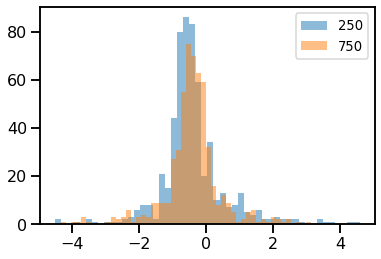

In [31]:
def adp_in_area(df_filter):

    gb_R1 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R1')].groupby(['area', 'cell_id']).sum()['dfof'].values
    gb_R2 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R2')].groupby(['area', 'cell_id']).sum()['dfof'].values
    gb_adp = (gb_R2 - gb_R1) / (gb_R1 + 1e-7)
    gb_adp = gb_adp[np.abs(gb_adp) < 5]

    return gb_adp

df_filter = df_tidy#[df_tidy.isi == 250]
gb_adp_250 = adp_in_area(df_filter[df_filter.isi == 250])
gb_adp_750 = adp_in_area(df_filter[df_filter.isi == 750])

plt.hist(gb_adp_250, bins=50, alpha=.5, label='250')
plt.hist(gb_adp_750, bins=50, alpha=.5, label='750')
plt.legend();

# adp_mean_arr = [np.mean(gb_adp_V1), np.mean(gb_adp_LM), np.mean(gb_adp_LI)]
# adp_med_arr = [np.median(gb_adp_V1), np.median(gb_adp_LM), np.median(gb_adp_LI)]
# adp_sem_arr = [np.std(gb_adp_V1) / np.sqrt(len(gb_adp_V1)), 
#                np.std(gb_adp_LM) / np.sqrt(len(gb_adp_LM)),
#                 np.std(gb_adp_LI) / np.sqrt(len(gb_adp_LI))]
# plt.errorbar([1, 2, 3], adp_mean_arr, yerr=adp_sem_arr, label='mean', alpha=.5)
# plt.errorbar([1, 2, 3], adp_med_arr, yerr=adp_sem_arr, label='median', alpha=.5)
# plt.xticks([1, 2, 3], ['V1', 'LM', 'LI']);
# plt.ylim([-1, 0]);
# plt.legend(frameon=False);

# sns.boxplot(data=[gb_adp_250, gb_adp_750], palette='Set2', notch=True, showfliers=False) # dont show the outliers beyond the caps
# plt.xticks([0, 1], ['250', '750']);
# plt.ylabel('adaptation index');
# sns.despine();

dir_fig = r'C:\Users\ll357\Documents\inter\results\tuning bias'.replace('\\', '/')
# plt.savefig(os.path.join(dir_fig, 'adp_grat8_by_area.pdf'))

# tuning bias preprocessing
x: distance(pref_ori_unadapted, 0 deg adapter_ori).binned  
y: distance(pref_ori_unadapted, 0 deg) - distance(pref_ori_adapted, 0 deg)

## pref_ori for cell & isi
~~crude preference: take max-resp orientation as the preferred orien~~  
fitted preference: use pref from von mises curve fit

In [29]:
# def bin_ori(x):
#     # bin pref ori to 0, 45, 90
#     if x < 30:
#         return 0
#     elif x <= 60:
#         return 45
#     else:
#         return 90

# def bin_ori_finer(x):
#     # bin pref ori to n bins, with equal bin width
#     nbin = 4 # n_edge = nbin + 1
#     bin_width = 90 / nbin
#     return (x // bin_width) * bin_width

# def distance_from_adapter(x):
#     # adapter is always 0 deg
#     # x = 22.5*x # convert from stim id int to degree
#     if x > 90:
#         x = 180 - x
#     return x


# df_tidy['pref_unadapted_distance'] = df_tidy['ori_pref_noad'].apply(lambda x: distance_from_adapter(x)) # unadapted pref ori, distance from adapter
# df_tidy['pref_unadapted_distance_bin'] = df_tidy['pref_unadapted_distance'].apply(lambda x: bin_ori(x)) # bin the distance to 0, 45, 90
# # df_tidy['pref_unadapted_distance_bin'] = df_tidy['pref_unadapted_distance'].apply(lambda x: bin_ori_finer(x)) # bin the distance to 5 edges, 0, 22.5, 45, 67.5, 90

# df_tidy.loc[(df_tidy.isi == 250), 'pref_adapted_distance'] = df_tidy['ori_pref_ad_250'].apply(lambda x: distance_from_adapter(x)) # isi 250 adapted pref ori, distance from adapter # TODO: refactor pref_ori_ad_250 similarly, so it's only one column of pref_ori_ad, but can filter by isi
# df_tidy.loc[(df_tidy.isi == 750), 'pref_adapted_distance'] = df_tidy['ori_pref_ad_750'].apply(lambda x: distance_from_adapter(x)) # isi 750 adapted pref ori, distance from adapter
# df_tidy['tuning_bias'] = df_tidy['pref_adapted_distance'] - df_tidy['pref_unadapted_distance'] # distance from adapter, adapted - unadapted. if tuning repelled from adapter, this is positive; attracted, negative

# df_tidy.sample(5, random_state=0)

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,...,ori_pref_noad2,filter_cell_well_fit_ad_250,filter_cell_well_fit_ad_750,mouse,date,sess,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias
2522359,0.064808,230323_003_32,8,R1,250,1,5,LI,0,False,...,179.737029,False,True,1374,230323,003,45.000000,45,60.088142,15.088142
1603041,-0.010087,230302_004_128,272,R2,250,1,3,LM,0,True,...,165.619769,True,False,1373,230302,004,9.709672,0,7.004356,-2.705316
1370059,-0.063766,230221_003_34,411,R2,6000,0,6,LM,0,False,...,67.409489,False,True,1380,230221,003,33.334788,45,NaN,NaN
2385126,-0.017126,230309_002_90,111,R2,250,1,3,LI,0,True,...,56.171587,True,True,1381,230309,002,45.000000,45,44.297625,-0.702375
123632,0.047451,200728_003_27,433,R2,6000,0,3,V1,0,True,...,89.631448,True,True,1324,200728,003,84.043607,90,NaN,NaN


In [30]:
# df_control = df_tidy.copy()

# df_control['pref_unadapted_distance'] = df_control['ori_pref_noad1'].apply(lambda x: distance_from_adapter(x)) # unadapted pref ori, distance from adapter
# df_control['pref_unadapted_distance_bin'] = df_control['pref_unadapted_distance'].apply(lambda x: bin_ori(x)) # bin the distance to 0, 45, 90
# # df_control['pref_unadapted_distance_bin'] = df_control['pref_unadapted_distance'].apply(lambda x: bin_ori_finer(x))

# df_control['pref_adapted_distance'] = df_control['ori_pref_noad2'].apply(lambda x: distance_from_adapter(x))
# df_control['tuning_bias'] = df_control['pref_adapted_distance'] - df_control['pref_unadapted_distance']

# df_control.sample(5, random_state=0)

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,...,ori_pref_noad2,filter_cell_well_fit_ad_250,filter_cell_well_fit_ad_750,mouse,date,sess,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias
2522359,0.064808,230323_003_32,8,R1,250,1,5,LI,0,False,...,179.737029,False,True,1374,230323,003,45.000000,45,0.262971,-44.737029
1603041,-0.010087,230302_004_128,272,R2,250,1,3,LM,0,True,...,165.619769,True,False,1373,230302,004,9.709672,0,14.380231,4.670560
1370059,-0.063766,230221_003_34,411,R2,6000,0,6,LM,0,False,...,67.409489,False,True,1380,230221,003,33.334788,45,67.409489,34.074701
2385126,-0.017126,230309_002_90,111,R2,250,1,3,LI,0,True,...,56.171587,True,True,1381,230309,002,45.000000,45,56.171587,11.171587
123632,0.047451,200728_003_27,433,R2,6000,0,3,V1,0,True,...,89.631448,True,True,1324,200728,003,84.043607,90,89.631448,5.587841


## merge df real vs control

In [118]:
# assert len(df_tidy) == len(df_control) # same number of rows
# assert (df_tidy.columns == df_control.columns).all() # all columns are the same
# assert np.sum(df_control['pref_unadapted_distance_bin'].values == df_tidy['pref_unadapted_distance_bin'].values) == len(df_tidy) # same pref_unadapted_distance_bin due to ori_pref_noad1 == ori_pref_noad
# assert np.sum(df_tidy.tuning_bias.values == df_control.tuning_bias.values) < len(df_tidy) # different tuning bias
# print('for tuning bias plot, only tuning bias col differs between control and real df')

for tuning bias plot, only tuning bias col differs between control and real df


In [32]:
# df_tidy['tuning_bias_control'] = df_control['tuning_bias']
df_tidy

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,filter_cell_stim,mouse,date,sess
0,0.123997,170324_674_0,0,R1,750,1,5,V1,0,True,False,674,170324,002-003
1,-0.020478,170324_674_0,1,R1,250,1,3,V1,0,True,False,674,170324,002-003
2,0.036473,170324_674_0,6,R1,250,1,5,V1,0,True,False,674,170324,002-003
3,-0.021505,170324_674_0,7,R1,750,1,3,V1,0,True,False,674,170324,002-003
4,0.018712,170324_674_0,9,R1,250,1,0,V1,0,True,False,674,170324,002-003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409445,-0.001696,170826_746_48,430,R2,250,1,4,V1,0,True,False,746,170826,002-003
409446,-0.023031,170826_746_48,431,R2,250,1,1,V1,0,True,False,746,170826,002-003
409447,-0.008022,170826_746_48,432,R2,750,1,2,V1,0,True,False,746,170826,002-003
409448,0.008595,170826_746_48,433,R2,250,1,7,V1,0,True,False,746,170826,002-003


## save & reload

In [33]:
dir_df = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
csv_filename = 'df_tidy_grat_8ori_3isi_miaomiao_jin.csv'

# chunks = np.array_split(df_tidy.index, 100) # split into 100 chunks
# for chunk, subset in enumerate(tqdm(chunks)):
#     if chunk == 0: # first row
#         df_tidy.loc[subset].to_csv(csv_filename, mode='w', index=True)
#     else:
#         df_tidy.loc[subset].to_csv(csv_filename, header=None, mode='a', index=True)

df_tidy = pd.read_csv(os.path.join(dir_df, csv_filename), index_col=0)

100%|██████████| 100/100 [00:02<00:00, 40.03it/s]


## if use all trials, not half trials
skipped

In [31]:
df_tidy_all_trials = pd.read_csv(os.path.join(dir_df, 'df_tidy_tuning_bias.csv'), index_col=0)
df_tidy_control_all_trials = pd.read_csv(os.path.join(dir_df, 'df_tidy_tuning_bias_control.csv'), index_col=0)

In [36]:
assert len(df_tidy_all_trials) == len(df_tidy_control_all_trials) # same number of rows
assert (df_tidy_all_trials.columns == df_tidy_control_all_trials.columns).all() # all columns are the same
# assert np.sum(df_tidy_control_all_trials['pref_unadapted_distance_bin'].values == df_tidy_all_trials['pref_unadapted_distance_bin'].values) == len(df_tidy_all_trials) # same pref_unadapted_distance_bin due to ori_pref_noad1 == ori_pref_noad
assert np.sum(df_tidy_all_trials.tuning_bias.values == df_tidy_control_all_trials.tuning_bias.values) < len(df_tidy_all_trials) # different tuning bias
print('for tuning bias plot, only tuning bias and pref_unadapted_distance_bin differs between control and real df')
df_tidy_all_trials['tuning_bias_control'] = df_tidy_control_all_trials['tuning_bias']
df_tidy_all_trials['pref_unadapted_distance_bin_control'] = df_tidy_control_all_trials['pref_unadapted_distance_bin']
df_tidy_all_trials

for tuning bias plot, only tuning bias and pref_unadapted_distance_bin differs between control and real df


,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,filter_cell_well_fit,...,filter_cell_well_fit_ad_750,mouse,date,sess,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias,tuning_bias_control,pref_unadapted_distance_bin_control
dfof,,,,,,,,,,,,,,,,,,,,,
-0.003253,200720_003_0,0,R1,750,1,5,V1,0,True,1.0,...,True,1323,200720,3,82.347391,90,73.637094,-8.710298,-1.662357,90
0.088726,200720_003_0,1,R1,250,1,2,V1,0,True,1.0,...,True,1323,200720,3,82.347391,90,68.247541,-14.099850,-1.662357,90
-0.010485,200720_003_0,2,R1,250,1,2,V1,0,True,1.0,...,True,1323,200720,3,82.347391,90,68.247541,-14.099850,-1.662357,90
-0.050493,200720_003_0,3,R1,750,1,3,V1,0,True,1.0,...,True,1323,200720,3,82.347391,90,73.637094,-8.710298,-1.662357,90
0.052611,200720_003_0,5,R1,750,1,0,V1,0,True,1.0,...,True,1323,200720,3,82.347391,90,73.637094,-8.710298,-1.662357,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.056616,230323_003_64,496,R2,6000,0,5,LI,0,False,0.0,...,False,1374,230323,3,7.524045,0,NaN,NaN,32.539719,0
0.077247,230323_003_64,497,R2,6000,0,6,LI,0,False,0.0,...,False,1374,230323,3,7.524045,0,NaN,NaN,32.539719,0
0.026982,230323_003_64,498,R2,250,1,6,LI,0,False,0.0,...,False,1374,230323,3,7.524045,0,31.946264,24.422218,32.539719,0


In [40]:
df_filter = df_tidy_all_trials[(df_tidy_all_trials.trial_id > -1) # placeholder, always true
                            & (df_tidy_all_trials.filter_cell_vis == True)
                            & (df_tidy_all_trials.filter_cell_well_fit == True)
                            & (df_tidy_all_trials.isi == 250)
                            ]
df_filter = df_filter.groupby('cell_id')[['area', 'pref_unadapted_distance_bin', 'pref_unadapted_distance_bin_control', 'tuning_bias', 'tuning_bias_control']].first().reset_index()
df_filter['tuning_bias_diff'] = df_filter['tuning_bias'] - df_filter['tuning_bias_control']
df_filter

,cell_id,area,pref_unadapted_distance_bin,pref_unadapted_distance_bin_control,tuning_bias,tuning_bias_control,tuning_bias_diff
0,200720_003_0,V1,90,90,-14.099850,-1.662357,-12.437493
1,200720_003_2,V1,90,90,-6.375618,0.529648,-6.905266
2,200720_003_22,V1,90,90,7.036726,0.703476,6.333250
3,200720_003_24,V1,0,0,14.101941,2.149425,11.952516
4,200720_003_25,V1,90,90,6.757597,1.970022,4.787575
...,...,...,...,...,...,...,...
632,230307_004_26,LM,0,0,4.357937,-8.113508,12.471445
633,230307_004_45,LM,45,45,-30.671126,5.708120,-36.379246
634,230307_004_47,LM,0,0,-15.573513,-7.068267,-8.505246
635,230309_002_44,LI,90,90,-50.296272,-1.398636,-48.897635


### tuning bias plot (all trials)

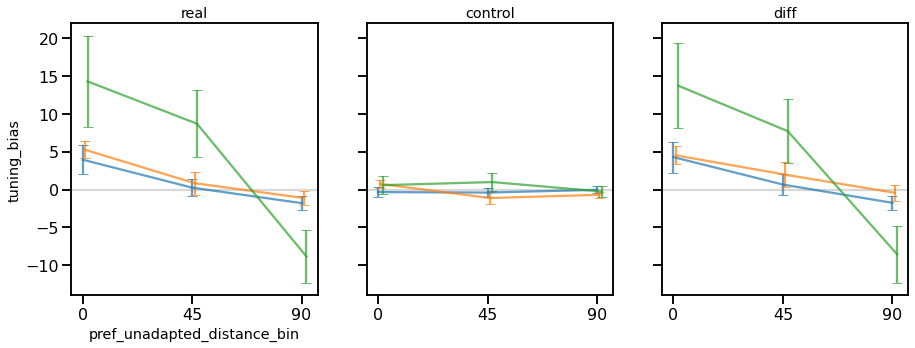

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
jitter = 1
for i, iarea in enumerate(df_filter.area.unique()):
    axes[0].errorbar(x=np.array(sorted(df_filter[df_filter.area == iarea].pref_unadapted_distance_bin.unique())) + i * jitter,
                    y=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias.mean(), 
                    yerr=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias.sem(), 
                    capsize=5, alpha=.7)


    axes[1].errorbar(x=np.array(sorted(df_filter[df_filter.area == iarea].pref_unadapted_distance_bin_control.unique())) + i * jitter,
                    y=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias_control.mean(),
                    yerr=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias_control.sem(),
                    capsize=5, alpha=.7)
    
    axes[2].errorbar(x=np.array(sorted(df_filter[df_filter.area == iarea].pref_unadapted_distance_bin.unique())) + i * jitter,
                    y=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias.mean() - df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias_control.mean(),
                    yerr=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias_diff.sem(),
                    capsize=5, alpha=.7)

axes[0].axhline(0, color='gray', linestyle='-', alpha=.3);
axes[1].axhline(0, color='gray', linestyle='-', alpha=.3);
axes[2].axhline(0, color='gray', linestyle='-', alpha=.3);

axes[0].set_title('real')
axes[0].set_xlabel('pref_unadapted_distance_bin')
axes[0].set_ylabel('tuning_bias')
axes[0].set_xticks([0, 45, 90])
axes[0].set_xticklabels([0, 45, 90])

axes[1].set_title('control');
axes[1].set_xticks([0, 45, 90])
axes[1].set_xticklabels([0, 45, 90])

axes[2].set_title('diff');
axes[2].set_xticks([0, 45, 90])
axes[2].set_xticklabels([0, 45, 90]);

### stats sig

In [50]:
pref_unadapted_distance_bin = 90
data = np.array([
                df_filter[(df_filter.area == 'V1') & (df_filter.pref_unadapted_distance_bin == pref_unadapted_distance_bin)].tuning_bias_diff.values,
                df_filter[(df_filter.area == 'LM') & (df_filter.pref_unadapted_distance_bin == pref_unadapted_distance_bin)].tuning_bias_diff.values,
                df_filter[(df_filter.area == 'LI') & (df_filter.pref_unadapted_distance_bin == pref_unadapted_distance_bin)].tuning_bias_diff.values,
                ], dtype=object)
data.shape, data[0].shape, data[1].shape, data[2].shape

((3,), (85,), (172,), (20,))

In [51]:
## t test
from scipy.stats import ttest_ind

## assumption: equal variance
print(np.var(data[0]), np.var(data[1]),) # assumption not met

t, p = ttest_ind(data[0], data[1], equal_var=False, alternative='less') #, permutations=10000, random_state=0)
t, p

71.34761782293795 185.11324610274514


(-0.9513678466644974, 0.17118402305896058)

In [52]:
## one way ANOVA
from scipy.stats import f_oneway

## assumption: equal variance
print(np.var(data[0]), np.var(data[1]), np.var(data[2]))
## assumption: normality
from scipy.stats import shapiro
print(shapiro(data[0]).pvalue, shapiro(data[1]).pvalue, shapiro(data[2]).pvalue)

f_oneway(data[0], data[1], data[2])

71.34761782293795 185.11324610274514 263.0468090748901
4.286658281671407e-07 1.632584685658505e-14 0.0015573829878121614


F_onewayResult(statistic=3.801247822372638, pvalue=0.023530258467825266)

In [53]:
from scipy.stats import kruskal
kruskal(data[0], data[1], data[2])

KruskalResult(statistic=9.896509703989182, pvalue=0.007095781318701659)

# tuning bias plot
skipped

In [270]:
df_filter = df_tidy[(df_tidy.trial_id > -1) # placeholder, always true
                    & (df_tidy.filter_cell_vis == True)
                  #   & (df_tidy.filter_cell_stim == True)
                    & (df_tidy.filter_cell_well_fit == True)
                    # & (df_tidy.filter_cell_well_fit_ad_250 == True)
                    & (df_tidy.isi == 250)
                    # & (df_tidy.filter_cell_well_fit_ad_750 == True)
                    # & (df_tidy.isi == 750)
                    ]
df_filter = df_filter.groupby('cell_id')[['area', 'pref_unadapted_distance_bin', 'tuning_bias', 'tuning_bias_control']].first().reset_index()
df_filter['tuning_bias_diff'] = df_filter['tuning_bias'] - df_filter['tuning_bias_control']
df_filter

,cell_id,area,pref_unadapted_distance_bin,tuning_bias,tuning_bias_control,tuning_bias_diff
0,200720_003_0,V1,90,-2.209110,2.857408,-5.066517
1,200720_003_2,V1,90,1.545071,8.433376,-6.888306
2,200720_003_22,V1,90,10.614124,-3.925642,14.539765
3,200720_003_24,V1,0,11.165754,-4.270538,15.436292
4,200720_003_25,V1,90,-7.029553,-3.337455,-3.692098
...,...,...,...,...,...,...
632,230307_004_26,LM,0,-12.258905,3.118108,-15.377012
633,230307_004_45,LM,90,-40.721540,-13.967277,-26.754263
634,230307_004_47,LM,0,7.807087,3.307979,4.499108
635,230309_002_44,LI,90,-65.059039,2.891672,-67.950710


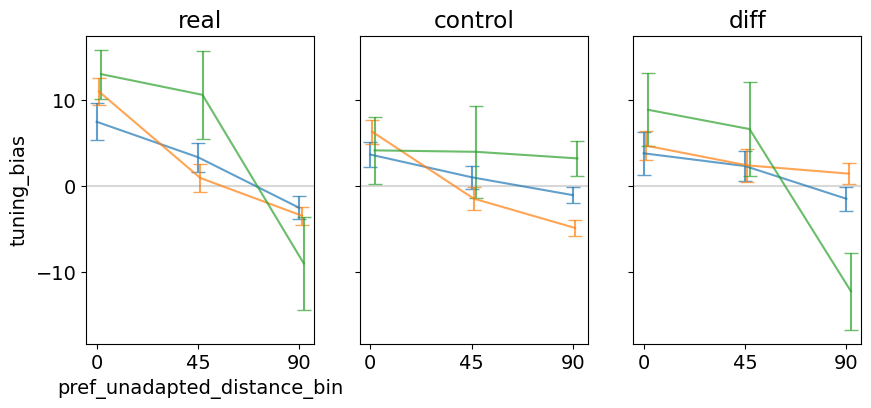

In [277]:
# set plt style to default
plt.style.use('default')

# set font size
plt.rcParams.update({'font.size': 14})

fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True, sharex=True)
jitter = 1
for i, iarea in enumerate(df_filter.area.unique()):
    axes[0].errorbar(x=np.array(sorted(df_filter[df_filter.area == iarea].pref_unadapted_distance_bin.unique())) + i * jitter,
                    y=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias.mean(), 
                    yerr=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias.sem(), 
                    capsize=5, alpha=.7)


    axes[1].errorbar(x=np.array(sorted(df_filter[df_filter.area == iarea].pref_unadapted_distance_bin.unique())) + i * jitter,
                    y=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias_control.mean(),
                    yerr=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias_control.sem(),
                    capsize=5, alpha=.7)
    
    axes[2].errorbar(x=np.array(sorted(df_filter[df_filter.area == iarea].pref_unadapted_distance_bin.unique())) + i * jitter,
                    y=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias_diff.mean(),
                    yerr=df_filter[df_filter.area == iarea].groupby('pref_unadapted_distance_bin').tuning_bias_diff.sem(),
                    capsize=5, alpha=.7)

axes[0].axhline(0, color='gray', linestyle='-', alpha=.3);
axes[1].axhline(0, color='gray', linestyle='-', alpha=.3);
axes[2].axhline(0, color='gray', linestyle='-', alpha=.3);

axes[0].set_title('real')
axes[0].set_xlabel('pref_unadapted_distance_bin')
axes[0].set_ylabel('tuning_bias')
axes[0].set_xticks([0, 45, 90])
axes[0].set_xticklabels([0, 45, 90])

axes[1].set_title('control');
axes[1].set_xticks([0, 45, 90])
axes[1].set_xticklabels([0, 45, 90])

axes[2].set_title('diff');
axes[2].set_xticks([0, 45, 90])
axes[2].set_xticklabels([0, 45, 90]);

fig.savefig(os.path.join(r'C:\Users\ll357\Documents\inter\results\tuning bias'.replace('\\', '/'), 'tuning_bias_by_area_with_control.pdf'), bbox_inches='tight')

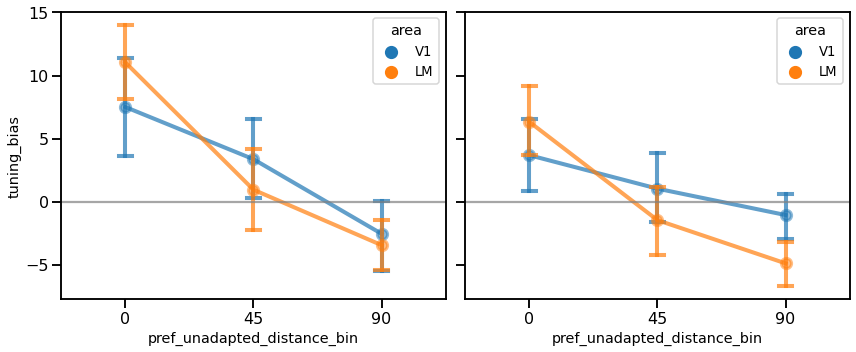

In [307]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
g1 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias', 
                   data=df_filter[df_filter.area != 'LI'], hue='area',
                   errorbar="se", errwidthfloat=1, capsize=.1,
                   ax=axes[0],
                   )
g2 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias_control', 
                   data=df_filter[df_filter.area != 'LI'], hue='area',
                   errorbar="se", errwidthfloat=1, capsize=.1,
                   ax=axes[1],
                  )
axes[0].axhline(0, color='gray', linestyle='-', alpha=.3);
axes[1].axhline(0, color='gray', linestyle='-', alpha=.3);

g2.set(ylabel=None) # remove ylabel
plt.setp(axes[0].collections, alpha=.5);
plt.setp(axes[1].collections, alpha=.5);
plt.setp(axes[0].lines, alpha=.7);
plt.setp(axes[1].lines, alpha=.7);
fig.tight_layout();

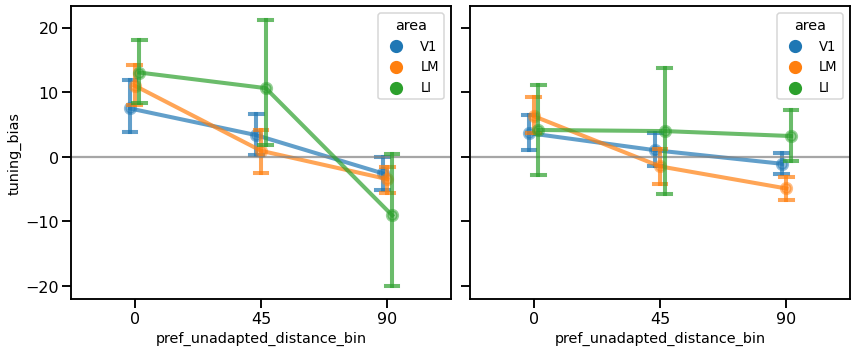

In [325]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
g1 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias', data=df_filter, hue='area',
                   errorbar="se", errwidthfloat=1, capsize=.1,
                   ax=axes[0], dodge=True,
                   )
g2 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias_control', data=df_filter, hue='area',
                  errorbar="se", errwidthfloat=1, capsize=.1,
                  ax=axes[1], dodge=True,
                  )
axes[0].axhline(0, color='gray', linestyle='-', alpha=.3);
axes[1].axhline(0, color='gray', linestyle='-', alpha=.3);

g2.set(ylabel=None) # remove ylabel
plt.setp(axes[0].collections, alpha=.5);
plt.setp(axes[1].collections, alpha=.5);
plt.setp(axes[0].lines, alpha=.7);
plt.setp(axes[1].lines, alpha=.7);
fig.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'tuning_bias_by_area.pdf'))

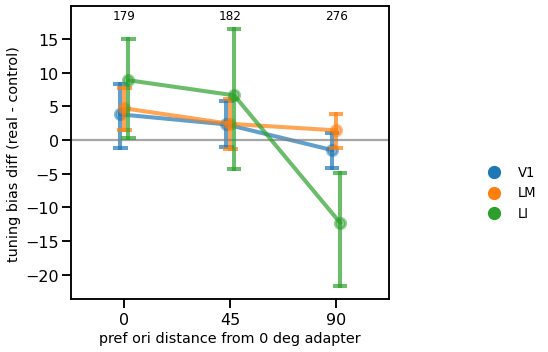

In [344]:
fig, axes = plt.subplots(1, 1, figsize=(9, 5), sharey=True)
g1 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias_diff', data=df_filter, hue='area',
                   errorbar='se', 
                #    errorbar=('ci', 68), 
                   errwidthfloat=1, capsize=.1,
                   ax=axes, dodge=True,
                   )

# annotation above each dot, ncell
ncell_bin = df_filter.groupby('pref_unadapted_distance_bin').cell_id.nunique().sort_index().values
ylim = axes.get_ylim()
axes.set_ylim(ylim[0], ylim[1] + 1.5)
for i in range(len(ncell_bin)):
    axes.annotate(str(ncell_bin[i]), (i, ylim[1] + 0.1), ha='center', va='center', size=12)

axes.legend(frameon=False, bbox_to_anchor=(1.5, 0.5))
g1.set(xlabel='pref ori distance from 0 deg adapter')
g1.set(ylabel='tuning bias diff (real - control)')
axes.axhline(0, color='gray', linestyle='-', alpha=.3);
plt.setp(axes.collections, alpha=.5);
plt.setp(axes.lines, alpha=.7);
fig.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'tuning_bias_control_diff_by_area.pdf'))

### stats sig

In [25]:
pref_unadapted_distance_bin = 90
data = np.array([
                df_filter[(df_filter.area == 'V1') & (df_filter.pref_unadapted_distance_bin == pref_unadapted_distance_bin)].tuning_bias_diff.values,
                df_filter[(df_filter.area == 'LM') & (df_filter.pref_unadapted_distance_bin == pref_unadapted_distance_bin)].tuning_bias_diff.values,
                df_filter[(df_filter.area == 'LI') & (df_filter.pref_unadapted_distance_bin == pref_unadapted_distance_bin)].tuning_bias_diff.values,
                ], dtype=object)
data.shape, data[0].shape, data[1].shape, data[2].shape

((3,), (84,), (175,), (17,))

In [26]:
## t test
from scipy.stats import ttest_ind

## assumption: equal variance
print(np.var(data[0]), np.var(data[1]),) # assumption not met

t, p = ttest_ind(data[0], data[1], equal_var=False, alternative='less') #, permutations=10000, random_state=0)
t, p

159.55193074673565 277.28870767509255


(-1.5635064143636679, 0.05972281688189927)

In [27]:
## one way ANOVA
from scipy.stats import f_oneway

## assumption: equal variance
print(np.var(data[0]), np.var(data[1]), np.var(data[2]))
## assumption: normality
from scipy.stats import shapiro
print(shapiro(data[0]).pvalue, shapiro(data[1]).pvalue, shapiro(data[2]).pvalue)

f_oneway(data[0], data[1], data[2])

159.55193074673565 277.28870767509255 322.2720352824679
8.062943201991857e-09 6.215306314061309e-08 0.0006468608044087887


F_onewayResult(statistic=6.259144877158457, pvalue=0.002198717293043121)

In [28]:
from scipy.stats import kruskal
kruskal(data[0], data[1], data[2])

KruskalResult(statistic=13.168785484999262, pvalue=0.0013817662007700436)

### ncell by area & well fit %

In [29]:
df_filter.groupby(['pref_unadapted_distance_bin', 'area']).cell_id.nunique(), \
df_tidy.groupby(['pref_unadapted_distance_bin', 'area']).cell_id.nunique(), 

(pref_unadapted_distance_bin  area
 0                            LI        5
                              LM      117
                              V1       57
 45                           LI       10
                              LM       87
                              V1       85
 90                           LI       17
                              LM      175
                              V1       84
 Name: cell_id, dtype: int64,
 pref_unadapted_distance_bin  area
 0                            LI      327
                              LM      739
                              V1      216
 45                           LI      238
                              LM      417
                              V1      176
 90                           LI      305
                              LM      559
                              V1      191
 Name: cell_id, dtype: int64)

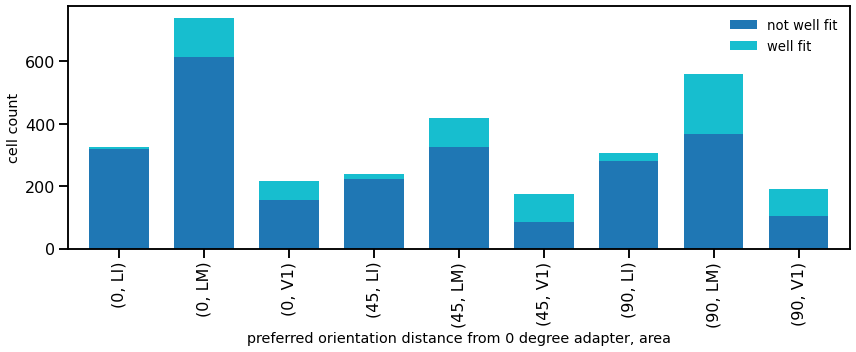

In [30]:
# stacked bar plot, colored by well_fit, for each area
df_tidy.groupby(['pref_unadapted_distance_bin', 'area', 'filter_cell_well_fit']).cell_id.nunique().unstack().plot(kind='bar', stacked=True, figsize=(12, 5), title='well_fit', colormap='tab10', legend='reverse', width=0.7);

# set legend frameon=False
plt.legend(frameon=False);

# set legend text content
plt.legend(['not well fit', 'well fit'], frameon=False);

plt.xlabel('preferred orientation distance from 0 degree adapter, area')
plt.ylabel('cell count')
plt.title('');
plt.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'well_fit_by_area.pdf'))

# df for tuning curve

In [35]:
df_tidy

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,filter_cell_stim,mouse,date,sess
0,0.123997,170324_674_0,0,R1,750,1,5,V1,0,True,False,674,170324,002-003
1,-0.020478,170324_674_0,1,R1,250,1,3,V1,0,True,False,674,170324,002-003
2,0.036473,170324_674_0,6,R1,250,1,5,V1,0,True,False,674,170324,002-003
3,-0.021505,170324_674_0,7,R1,750,1,3,V1,0,True,False,674,170324,002-003
4,0.018712,170324_674_0,9,R1,250,1,0,V1,0,True,False,674,170324,002-003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409445,-0.001696,170826_746_48,430,R2,250,1,4,V1,0,True,False,746,170826,002-003
409446,-0.023031,170826_746_48,431,R2,250,1,1,V1,0,True,False,746,170826,002-003
409447,-0.008022,170826_746_48,432,R2,750,1,2,V1,0,True,False,746,170826,002-003
409448,0.008595,170826_746_48,433,R2,250,1,7,V1,0,True,False,746,170826,002-003


In [37]:
df_tuning = df_tidy[['dfof', 'cell_id', 'resp_id', 'isi', 'stim2_id', 
                    'area', 'filter_cell_vis', 
                    # 'filter_cell_well_fit', 'filter_cell_well_fit_ad_250', 
                    # 'ori_pref_ad_250', 'ori_pref_noad', 
                    # 'pref_unadapted_distance', 'pref_unadapted_distance_bin', 'pref_adapted_distance', 
                    # 'tuning_bias', 'tuning_bias_control',
                    ]]
df_tuning = df_tuning[(df_tuning.isi > -1) # placeholder, always true
                    # & (df_tuning.area == 'LI')
                    & (df_tuning.filter_cell_vis == True)
                    # & (df_tuning.filter_cell_well_fit == True)
                    # & (df_tuning.filter_cell_well_fit_ad_250 == True) # only use cells that are well fit in both conditions: noad and ad 250
                    & ((df_tuning.isi == 250) | (df_tuning.isi == 6000))
                    # & (df_tuning.pref_unadapted_distance_bin == 90)
                    ]
                    
df_tuning['tuning_noad'] = np.pi
df_tuning['tuning_250'] = np.pi

for icell in tqdm(df_tuning.cell_id.unique()):
    ## tuning curve when isi = 6000, no adapter
    tuning_noad = df_tuning.loc[(df_tuning.cell_id == icell) & (df_tuning.isi == 6000) & (df_tuning.resp_id == 'R2'), :].groupby(['stim2_id'], sort=True).agg(np.nanmean)['dfof'].values# groupby sort: sorted by key, aka stim2_id. take R2 of no adapter trials to get tuning curve when no adapter
    df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_noad'] = df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_noad'].apply(lambda x: tuning_noad)
    
    ## tuning curve when isi = 250
    tuning_250 = df_tuning.loc[(df_tuning.cell_id == icell) & (df_tuning.isi == 250) & (df_tuning.resp_id == 'R2'), :].groupby(['stim2_id'], sort=True).agg(np.nanmean)['dfof'].values
    df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_250'] = df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_250'].apply(lambda x: tuning_250)

# df_tuning.sort_values(by=['tuning_bias'], inplace=True) # df_tuning sort by tuning_bias_distance
df_tuning.sample(5, random_state=0) # NOTE: where isi=6000, pref_adapted_distance and tuning_bias are NaN

,dfof,cell_id,resp_id,isi,stim2_id,area,filter_cell_vis,tuning_noad,tuning_250
355596,0.262515,170816_745_25,R2,6000,6,V1,True,"[0.06465830069530332, 0.07024384359223879, 0.0...","[0.005895489556718416, 0.05985420929606872, 0...."
97009,0.151056,170323_696_22,R2,6000,0,V1,True,"[0.037358763261636965, 0.012934330930654714, 0...","[0.01672618394299408, 0.014321049307267618, 0...."
107559,-0.058787,170323_696_48,R2,6000,1,V1,True,"[0.006725637630569131, 0.01842489243566174, 0....","[0.006200666599943769, 0.011817575997853614, 0..."
204457,0.129164,170510_574_45,R1,250,1,V1,True,"[0.37430977985382125, 0.3092807275032376, 0.31...","[0.011177160284064675, 0.034885655201533895, 0..."
363638,0.165652,170816_745_43,R2,6000,3,V1,True,"[0.09779181625472327, 0.1403293338584462, 0.14...","[0.07699930186329468, 0.1522313596053068, 0.15..."


## polar plot of tuning
before and after adaptation  
filter cells  
skipped

In [258]:
# df_tuning = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False)
# df_tuning.groupby('cell_id', sort=False)['area', 'gOSI_noad', 'gOSI_250'].first()#.head(20)

In [ ]:
for icell in tqdm(df_tuning.cell_id.unique()):

    gOSI_noad = df_tuning[df_tuning.cell_id == icell].gOSI_noad.values[0]
    gOSI_250 = df_tuning[df_tuning.cell_id == icell].gOSI_250.values[0]

    tuning_noad = df_tuning[df_tuning.cell_id == icell].tuning_noad.values[0]
    tuning_noad = np.append(tuning_noad, tuning_noad) # repeat 8 values twice to make 16 values for polar plot
    tuning_noad = np.append(tuning_noad, tuning_noad[0]) # repeat first value at the end to close the circle
    ori_pref_noad = df_tuning[df_tuning.cell_id == icell].ori_pref_noad.values[0]
    # print('ori_pref_noad deg: ', np.round(ori_pref_noad, 2))
    ori_pref_noad = ori_pref_noad * np.pi / 180 # degree to radian

    tuning_250 = df_tuning[df_tuning.cell_id == icell].tuning_250.values[0]
    tuning_250 = np.append(tuning_250, tuning_250)
    tuning_250 = np.append(tuning_250, tuning_250[0])
    ori_pref_ad_250 = df_tuning[df_tuning.cell_id == icell].ori_pref_ad_250.values[0]
    # print('ori_pref_ad_250 deg: ', np.round(ori_pref_ad_250, 2))
    ori_pref_ad_250 = ori_pref_ad_250 * np.pi / 180

    tuning_bias = df_tuning[df_tuning.cell_id == icell].tuning_bias.values[0]
    # print('no adapter: ', np.round(tuning_noad, 2))
    # print('250 ms: ', np.round(tuning_250, 2))
    # print('tuning_bias: ', np.round(tuning_bias, 2))

    fig, ax = plt.subplots(1, 1, figsize=(12, 12), subplot_kw=dict(projection='polar'))
    ax.plot(np.linspace(0, 2*np.pi, 17), tuning_noad, alpha=.5, linewidth=10)
    ax.plot(np.linspace(0, 2*np.pi, 17), tuning_250, alpha=.5, linewidth=10)

    # plot adapter ori as a line
    min_val = np.min([np.min(tuning_noad), np.min(tuning_250)])
    max_val = np.max([np.max(tuning_noad), np.max(tuning_250)])
    # ax.plot([0, np.pi], [max_val, max_val], color='gray', linewidth=5, alpha=.5, label='adapter ori')

    # ## plot 90 deg as a line
    # ax.plot([np.pi/2, np.pi/2], [min_val, max_val], color='cyan', linewidth=5, alpha=.5, linestyle='-')
    # ax.plot([np.pi*3/2, np.pi*3/2], [min_val, max_val], color='cyan', linewidth=5, alpha=.5, linestyle='-')

    ## plot pref ori (noad) as a line
    ax.plot([ori_pref_noad, ori_pref_noad], [min_val, max_val], color='blue', linewidth=5, alpha=.5, label='pref ori no adapter')
    ori_pref_noad_opp = ori_pref_noad + np.pi # find opposite orientation of pref ori
    if ori_pref_noad_opp > 2*np.pi:
        ori_pref_noad_opp = ori_pref_noad_opp - 2*np.pi
    ax.plot([ori_pref_noad_opp, ori_pref_noad_opp], [min_val, max_val], color='blue', linewidth=5, alpha=.5, linestyle='-')

    ## plot pref ori (ad 250) as a line
    ax.plot([ori_pref_ad_250, ori_pref_ad_250], [min_val, max_val], color='orange', linewidth=5, alpha=.5, label='pref ori isi=250')
    ori_pref_ad_250_opp = ori_pref_ad_250 + np.pi
    if ori_pref_ad_250_opp > 2*np.pi:
        ori_pref_ad_250_opp = ori_pref_ad_250_opp - 2*np.pi
    ax.plot([ori_pref_ad_250_opp, ori_pref_ad_250_opp], [min_val, max_val], color='orange', linewidth=5, alpha=.5, linestyle='-')

    ## add text at top left
    bias_color = 'blue'
    minus_flag = 'pos'
    if tuning_bias < 0: # attractive bias
        bias_color = 'red'
        minus_flag = 'neg'
    plt.text(0.05, 0.9, f'tuning_bias: {np.round(tuning_bias, 2)}', transform=plt.gcf().transFigure, color=bias_color, fontsize=16) # in cartesian coordinates
    gOSI_color = 'green'
    if gOSI_noad < 0.5 or gOSI_250 < 0.5:
        gOSI_color = 'orange'
    if gOSI_noad < 0.5 and gOSI_250 < 0.5:
        gOSI_color = 'red'
    plt.text(0.05, 0.85, f'gOSI_noad: {np.round(gOSI_noad, 2)}', transform=plt.gcf().transFigure, color=gOSI_color, fontsize=16) # in cartesian coordinates
    plt.text(0.05, 0.8, f'gOSI_250: {np.round(gOSI_250, 2)}', transform=plt.gcf().transFigure, color=gOSI_color, fontsize=16) # in cartesian coordinates

    rticks = np.arange(0, max_val, step=0.05)
    ax.set_rticks(rticks)  # fewer radial ticks

    ax.set_xticks(np.linspace(0, 2*np.pi, 17))
    ax.set_xticklabels(np.arange(0, 360+22.5, 22.5))
    xticklabels = [label.get_text() for label in ax.get_xticklabels()]
    xticklabels[-1] = '' # set final xticklabel invisible
    ax.set_xticklabels(xticklabels)
    ax.set_ylim(min_val, max_val)

    area = df_tuning[df_tuning.cell_id == icell].area.values[0]
    ax.set_title(f'cell_id {icell} in {area}')
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.legend(bbox_to_anchor=(1.1, 1.1), frameon=False); # set legend position out of the way

    # break

    # save figure
    dir_result = r'C:\Users\ll357\Documents\inter\results\tuning bias single cell'.replace('\\', '/')
    fig.savefig(os.path.join(dir_result, 'gOSI', f'gOSI_{np.round(gOSI_noad, 2)}_{icell}_tuning_curve.png'), bbox_inches='tight', dpi=300)
    plt.close(fig)
    clear_output(wait=True)

100%|██████████| 637/637 [13:34<00:00,  1.28s/it]


## filter cell gOSI
for well fit cells, calculate global orientation selectivity index (gOSI)  
formula taken from [Causal importance of orientation selectivity for generalization in image recognition](https://openreview.net/pdf?id=Bkx_Dj09tQ)

In [38]:
for icell in tqdm(df_tuning.cell_id.unique()):
    df_cell = df_tuning[df_tuning.cell_id == icell]

    tuning_noad = df_cell.tuning_noad.values[0] - min(df_cell.tuning_noad.values[0]) # ensure all values are non negative
    tuning_250 = df_cell.tuning_250.values[0] - min(df_cell.tuning_250.values[0])

    theta_arr = np.linspace(0, 180-22.5, 8) # according to formula: unit deg, not rad
    sin_arr = np.sin(2 * theta_arr)
    cos_arr = np.cos(2 * theta_arr)

    gOSI_noad = np.sqrt((np.sum(tuning_noad * sin_arr))**2 + (np.sum(tuning_noad * cos_arr))**2) / np.sum(tuning_noad)
    gOSI_250 = np.sqrt((np.sum(tuning_250 * sin_arr))**2 + (np.sum(tuning_250 * cos_arr))**2) / np.sum(tuning_250)

    df_tuning.loc[df_tuning.cell_id == icell, 'gOSI_noad'] = gOSI_noad
    df_tuning.loc[df_tuning.cell_id == icell, 'gOSI_250'] = gOSI_250

df_tuning

100%|██████████| 482/482 [00:14<00:00, 32.53it/s]


,dfof,cell_id,resp_id,isi,stim2_id,area,filter_cell_vis,tuning_noad,tuning_250,gOSI_noad,gOSI_250
1,-0.020478,170324_674_0,R1,250,3,V1,True,"[-0.0013643157915699125, 0.005271318457939338,...","[0.008913068308823267, -0.021396008957600476, ...",0.324613,0.301693
2,0.036473,170324_674_0,R1,250,5,V1,True,"[-0.0013643157915699125, 0.005271318457939338,...","[0.008913068308823267, -0.021396008957600476, ...",0.324613,0.301693
4,0.018712,170324_674_0,R1,250,0,V1,True,"[-0.0013643157915699125, 0.005271318457939338,...","[0.008913068308823267, -0.021396008957600476, ...",0.324613,0.301693
5,0.094969,170324_674_0,R1,250,5,V1,True,"[-0.0013643157915699125, 0.005271318457939338,...","[0.008913068308823267, -0.021396008957600476, ...",0.324613,0.301693
6,0.043600,170324_674_0,R1,250,1,V1,True,"[-0.0013643157915699125, 0.005271318457939338,...","[0.008913068308823267, -0.021396008957600476, ...",0.324613,0.301693
...,...,...,...,...,...,...,...,...,...,...,...
409443,-0.037524,170826_746_48,R2,6000,6,V1,True,"[0.03889302421285534, 0.02247627182215986, 0.0...","[0.00019849356526639936, 0.04753583625073863, ...",0.382866,0.436267
409444,-0.089406,170826_746_48,R2,6000,0,V1,True,"[0.03889302421285534, 0.02247627182215986, 0.0...","[0.00019849356526639936, 0.04753583625073863, ...",0.382866,0.436267
409445,-0.001696,170826_746_48,R2,250,4,V1,True,"[0.03889302421285534, 0.02247627182215986, 0.0...","[0.00019849356526639936, 0.04753583625073863, ...",0.382866,0.436267
409446,-0.023031,170826_746_48,R2,250,1,V1,True,"[0.03889302421285534, 0.02247627182215986, 0.0...","[0.00019849356526639936, 0.04753583625073863, ...",0.382866,0.436267


In [42]:
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# df_tuning.sort_values(by='area', ascending=False).groupby(['area', 'cell_id'], sort=False).gOSI_noad.hist(bins=20, alpha=.5, ax=axes[0]);
# df_tuning.sort_values(by='area', ascending=False).groupby(['area', 'cell_id'], sort=False).gOSI_250.hist(bins=20, alpha=.5, ax=axes[1]);

# # axes[0].legend(['V1', 'LM', 'LI',], frameon=False) # sorted area descending
# plt.tight_layout();
# ## indeed, gOSI is between 0 and 1. higher gOSI means more orientation selective

In [44]:
df_tuning.groupby('area').gOSI_noad.describe() # df tuning is well-fit cells only. even so, LI gOSI is much worse than V1 and LM

,count,mean,std,min,25%,50%,75%,max
area,,,,,,,,
V1,198929.0,0.435225,0.172293,0.015039,0.307736,0.435505,0.556673,0.847809


In [45]:
# df_tidy.groupby('area').filter_cell_well_fit.describe() # well fit cell filter discards most cells in LI already

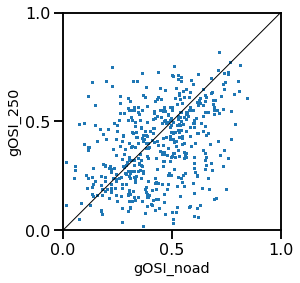

In [46]:
tmp1 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).gOSI_noad.values
tmp2 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).gOSI_250.values
# tmp3 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).tuning_bias.values

plt.scatter(tmp1, tmp2, alpha=.1, s=1);
plt.plot([0, 1], [0, 1], color='k', linestyle='-', linewidth=1); # draw diagonal line

plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.xticks([0, .5, 1]);
plt.yticks([0, .5, 1]);
plt.xlabel('gOSI_noad');
plt.ylabel('gOSI_250');
plt.gca().set_aspect('equal', adjustable='box'); # set axis square

## gOSI noad is usually higher. gOSI noad vs 250 is correlated

r2 score of gOSI_noad vs tuning_bias:  0.01999189972339943
r2 score of gOSI_250 vs tuning_bias:  0.0034475291680431397
slope:  15.293958524937405
intercept:  -6.300087231468615
positive correlation between gOSI and tuning_bias


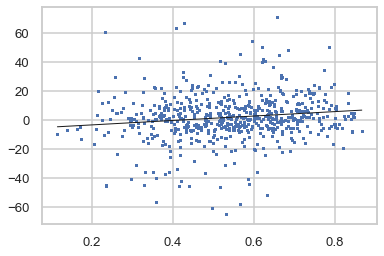

In [264]:
# ## regression: gOSI vs tuning_bias
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import r2_score

# tmp1 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).gOSI_noad.values
# tmp2 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).gOSI_250.values
# tmp3 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).tuning_bias.values
# tmp1 = tmp1[~np.isnan(tmp3)]
# tmp2 = tmp2[~np.isnan(tmp3)]
# tmp3 = tmp3[~np.isnan(tmp3)]
# tmp1 = tmp1.reshape(-1, 1)
# tmp2 = tmp2.reshape(-1, 1)
# tmp3 = tmp3.reshape(-1, 1)

# reg1 = LinearRegression().fit(tmp1, tmp3)
# reg2 = LinearRegression().fit(tmp2, tmp3)
# print('r2 score of gOSI_noad vs tuning_bias: ', r2_score(tmp3, reg1.predict(tmp1)))
# print('r2 score of gOSI_250 vs tuning_bias: ', r2_score(tmp3, reg2.predict(tmp2)))

# plt.scatter(tmp1, tmp3, alpha=.1, s=1);
# plt.plot(tmp1, reg1.predict(tmp1), color='k', linestyle='-', linewidth=1);
# print('slope: ', reg1.coef_[0][0])
# print('intercept: ', reg1.intercept_[0])

# print('positive correlation between gOSI and tuning_bias')

### tuning bias plot - high gOSI
didnt seem to help  
skipped

In [265]:
gOSI_thres = 0.5 # In visual neuroscience, neurons with gOSI > 0.33 are often considered to be orientation-selective (Piscopo et al., 2013; Kondo & Ohki, 2015).
df_tuning_gOSI = df_tuning[(df_tuning.gOSI_noad > gOSI_thres) & (df_tuning.gOSI_250 > gOSI_thres)]
print(df_tuning_gOSI.groupby('area').cell_id.nunique())

df_tuning_gOSI = df_tuning_gOSI.groupby('cell_id')[['area', 'pref_unadapted_distance_bin', 'tuning_bias', 'tuning_bias_control']].first().reset_index()
df_tuning_gOSI

area
LI     10
LM    152
V1     94
Name: cell_id, dtype: int64


,cell_id,area,pref_unadapted_distance_bin,tuning_bias,tuning_bias_control
0,200720_003_24,V1,0,11.165754,-4.270538
1,200720_003_29,V1,0,4.465665,6.922370
2,200720_003_57,V1,0,13.236476,0.945789
3,200720_003_59,V1,45,54.626962,7.780432
4,200720_003_61,V1,45,-0.369852,-10.973383
...,...,...,...,...,...
251,230307_004_24,LM,0,28.209884,6.004743
252,230307_004_26,LM,0,-12.258905,3.118108
253,230307_004_45,LM,90,-40.721540,-13.967277
254,230307_004_47,LM,0,7.807087,3.307979


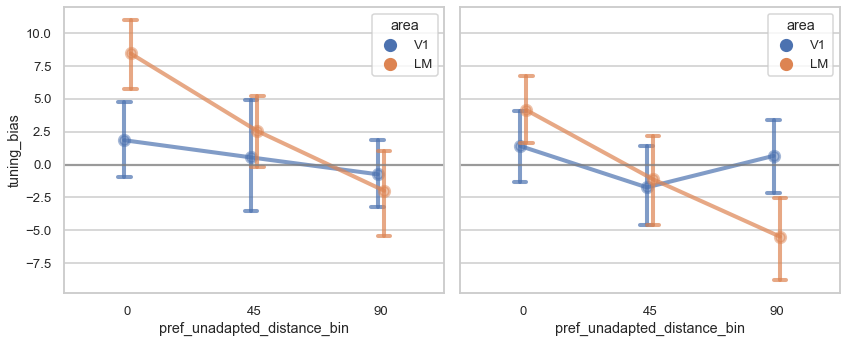

In [266]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
g1 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias', 
                   data=df_tuning_gOSI[df_tuning_gOSI.area != 'LI'], hue='area',
                   errorbar='sd', # ('ci', 68), 
                   errwidthfloat=1, capsize=.1,
                   ax=axes[0], dodge=True,
                   )
g2 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias_control', 
                   data=df_tuning_gOSI[df_tuning_gOSI.area != 'LI'], hue='area',
                  errorbar=('ci', 68), errwidthfloat=1, capsize=.1,
                  ax=axes[1], dodge=True, legend=False,
                  )
axes[0].axhline(0, color='gray', linestyle='-', alpha=.3);
axes[1].axhline(0, color='gray', linestyle='-', alpha=.3);

g2.set(ylabel=None) # remove ylabel
plt.setp(axes[0].collections, alpha=.5);
plt.setp(axes[1].collections, alpha=.5);
plt.setp(axes[0].lines, alpha=.7);
plt.setp(axes[1].lines, alpha=.7);
fig.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'tuning_bias_by_area.pdf'))

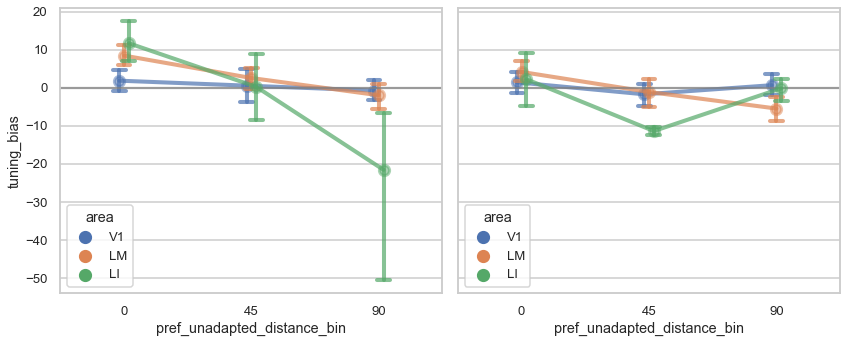

In [267]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
g1 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias', data=df_tuning_gOSI, hue='area',
                   errorbar='sd', # ('ci', 68), 
                   errwidthfloat=1, capsize=.1,
                   ax=axes[0], dodge=True,
                   )
g2 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias_control', data=df_tuning_gOSI, hue='area',
                  errorbar=('ci', 68), errwidthfloat=1, capsize=.1,
                  ax=axes[1], dodge=True, legend=False,
                  )
axes[0].axhline(0, color='gray', linestyle='-', alpha=.3);
axes[1].axhline(0, color='gray', linestyle='-', alpha=.3);

g2.set(ylabel=None) # remove ylabel
plt.setp(axes[0].collections, alpha=.5);
plt.setp(axes[1].collections, alpha=.5);
plt.setp(axes[0].lines, alpha=.7);
plt.setp(axes[1].lines, alpha=.7);
fig.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'tuning_bias_by_area.pdf'))

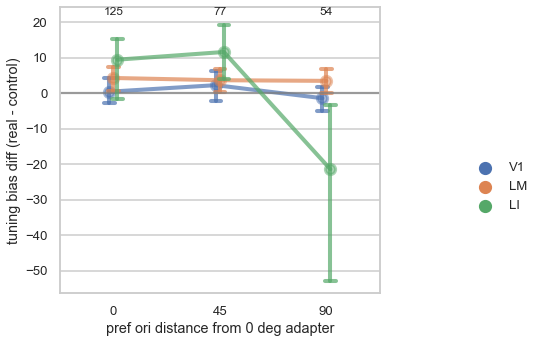

In [268]:
df_tuning_gOSI['tuning_bias_diff'] = df_tuning_gOSI['tuning_bias'] - df_tuning_gOSI['tuning_bias_control']

fig, axes = plt.subplots(1, 1, figsize=(9, 5), sharey=True)
g1 = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias_diff', data=df_tuning_gOSI, hue='area',
                   errorbar=('ci', 68), errwidthfloat=1, capsize=.1,
                   ax=axes, dodge=True,
                   )

# annotation above each dot, ncell
ncell_bin = df_tuning_gOSI.groupby('pref_unadapted_distance_bin').cell_id.nunique().sort_index().values
ylim = axes.get_ylim()
axes.set_ylim(ylim[0], ylim[1] + 1.5)
for i in range(len(ncell_bin)):
    axes.annotate(str(ncell_bin[i]), (i, ylim[1] + 0.1), ha='center', va='center', size=12)

axes.legend(frameon=False, bbox_to_anchor=(1.5, 0.5))
g1.set(xlabel='pref ori distance from 0 deg adapter')
g1.set(ylabel='tuning bias diff (real - control)')
axes.axhline(0, color='gray', linestyle='-', alpha=.3);
plt.setp(axes.collections, alpha=.5);
plt.setp(axes.lines, alpha=.7);
fig.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'tuning_bias_control_diff_by_area.pdf'))

## filter cell ori-mod
dont fit tuning curve, dont filter well fit cells.  
find orientation-modulated cells by anova across all orientations responses

In [81]:
df_tidy#.columns

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,filter_cell_stim,mouse,date,sess
0,0.123997,170324_674_0,0,R1,750,1,5,V1,0,True,False,674,170324,002-003
1,-0.020478,170324_674_0,1,R1,250,1,3,V1,0,True,False,674,170324,002-003
2,0.036473,170324_674_0,6,R1,250,1,5,V1,0,True,False,674,170324,002-003
3,-0.021505,170324_674_0,7,R1,750,1,3,V1,0,True,False,674,170324,002-003
4,0.018712,170324_674_0,9,R1,250,1,0,V1,0,True,False,674,170324,002-003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409445,-0.001696,170826_746_48,430,R2,250,1,4,V1,0,True,False,746,170826,002-003
409446,-0.023031,170826_746_48,431,R2,250,1,1,V1,0,True,False,746,170826,002-003
409447,-0.008022,170826_746_48,432,R2,750,1,2,V1,0,True,False,746,170826,002-003
409448,0.008595,170826_746_48,433,R2,250,1,7,V1,0,True,False,746,170826,002-003


In [82]:
cell_property = (df_tidy[['cell_id', 'isi', 'area', 'filter_cell_vis']] # need cell info: area, vis driven
                 .groupby(['cell_id', 'isi']) # prepare to match with df_ori_mod
                 .first() # only take first value. all values should be the same for each cell and isi combination
                 .reset_index())
cell_property

,cell_id,isi,area,filter_cell_vis
0,170323_689_0,250,V1,True
1,170323_689_0,750,V1,True
2,170323_689_0,6000,V1,True
3,170323_689_1,250,V1,False
4,170323_689_1,750,V1,False
...,...,...,...,...
1756,170826_746_8,750,V1,False
1757,170826_746_8,6000,V1,False
1758,170826_746_9,250,V1,True
1759,170826_746_9,750,V1,True


In [83]:
## construct tuning_vec column

df_ori_mod = (df_tidy[df_tidy.resp_id == 'R2'] # only R2 has diff ori
            [['dfof', 'cell_id', 'resp_id', 'isi', 'stim2_id']]
              .groupby(['cell_id', 'isi', 'stim2_id']).agg({'dfof': 'mean'}) # aggregate resp by cell, isi, ori
              .groupby(['cell_id', 'isi']).agg({'dfof':lambda x: list(x)}) # each row is a list of aggregated resp across ori
              .reset_index()
              .rename(columns={'dfof': 'tuning_vec'})
              .merge(cell_property, on=['cell_id', 'isi'], how='left') # merge with cell info
            )
df_ori_mod

,cell_id,isi,tuning_vec,area,filter_cell_vis
0,170323_689_0,250,"[0.0388499074107737, 0.028516304864018502, 0.0...",V1,True
1,170323_689_0,750,"[0.039857768164824586, 0.04167231509353064, 0....",V1,True
2,170323_689_0,6000,"[0.06338796165153944, 0.07376063577681458, 0.0...",V1,True
3,170323_689_1,250,"[-0.006239601434112747, 0.028367459482903187, ...",V1,False
4,170323_689_1,750,"[0.007579799649491357, 0.022330068866486825, -...",V1,False
...,...,...,...,...,...
1756,170826_746_8,750,"[0.06214298595549563, 0.029010662909225143, 0....",V1,False
1757,170826_746_8,6000,"[0.059667259379216624, 0.061716979140053745, 0...",V1,False
1758,170826_746_9,250,"[0.05575754865272174, 0.015433443446375945, 0....",V1,True
1759,170826_746_9,750,"[0.016734280333430957, 0.04087381565284569, 0....",V1,True


In [84]:
## construct ori_mod column

from scipy.stats import kruskal
p_threshold = 0.05

df_kruskal = (df_tidy[df_tidy.resp_id == 'R2'] # only R2 has diff ori
            [['dfof', 'cell_id', 'isi', 'stim2_id']]
            .groupby(['cell_id', 'isi', 'stim2_id']) # for each cell, each isi condition, calc responses to each ori
            .agg({'dfof':lambda x: list(x)}) # each row, dfof col contains a list of ori responses across trials
            .reset_index()
            .groupby(['cell_id', 'isi']) # for each cell, each isi condition, calc ori modulation
            .apply(lambda x: kruskal(*x.dfof.values).pvalue < p_threshold) # kruskal, where each ori is a group
            .reset_index()
            )
df_kruskal = df_kruskal.rename(columns={0: 'ori_mod'}) # bool col for ori modulation

df_ori_mod = df_ori_mod.merge(df_kruskal, on=['cell_id', 'isi'], how='left')
df_ori_mod

,cell_id,isi,tuning_vec,area,filter_cell_vis,ori_mod
0,170323_689_0,250,"[0.0388499074107737, 0.028516304864018502, 0.0...",V1,True,False
1,170323_689_0,750,"[0.039857768164824586, 0.04167231509353064, 0....",V1,True,False
2,170323_689_0,6000,"[0.06338796165153944, 0.07376063577681458, 0.0...",V1,True,False
3,170323_689_1,250,"[-0.006239601434112747, 0.028367459482903187, ...",V1,False,False
4,170323_689_1,750,"[0.007579799649491357, 0.022330068866486825, -...",V1,False,False
...,...,...,...,...,...,...
1756,170826_746_8,750,"[0.06214298595549563, 0.029010662909225143, 0....",V1,False,True
1757,170826_746_8,6000,"[0.059667259379216624, 0.061716979140053745, 0...",V1,False,False
1758,170826_746_9,250,"[0.05575754865272174, 0.015433443446375945, 0....",V1,True,False
1759,170826_746_9,750,"[0.016734280333430957, 0.04087381565284569, 0....",V1,True,False


In [85]:
## construct max_ori and max_ori_distance column

df_ori_mod['max_ori'] = df_ori_mod.tuning_vec.apply(lambda x: np.argmax(x)) # NOTE: even though we calculated max_ori for isi 250 and 750, only isi 6000 was actually used below (inherited by df_lineplot)
df_ori_mod['max_ori_dist'] = df_ori_mod.max_ori.apply(lambda x: 22.5*(8-x) if x > 4 else 22.5*x) # distance from 0 deg, hard coded for 8 ori. TODO: modify if needed

# df_ori_mod.groupby('max_ori').max_ori_distance.value_counts()
# df_ori_mod.groupby('max_ori_distance').max_ori.value_counts()
df_ori_mod.groupby('max_ori').max_ori_dist.unique()

max_ori
0     [0.0]
1    [22.5]
2    [45.0]
3    [67.5]
4    [90.0]
5    [67.5]
6    [45.0]
7    [22.5]
Name: max_ori_dist, dtype: object

In [111]:
## prepare for lineplot. don't need tuning vec, but need (stim2_id, dfof) observations
df_lineplot = (df_tidy[df_tidy.resp_id == 'R2'] # only R2 has diff ori
                      [['dfof', 'cell_id', 
                        'area', 'filter_cell_vis',
                        'resp_id', 'isi', 'stim2_id']]
                        .reset_index(drop=True)
                        )

## inherit ori_mod, max_ori, max_ori_distance from df_ori_mod
df_lineplot = df_lineplot.merge(
      df_ori_mod[df_ori_mod.isi == 6000]
      [['cell_id', 'ori_mod', 'max_ori', 'max_ori_dist', ]], 
      on=['cell_id'], how='left') # only use isi 6000 (no adapter condition) to determine ori_mod, max_ori and max_ori_dist for each cell

## inherit tuning_vec from df_ori_mod, for each isi
df_lineplot = df_lineplot.merge(
      df_ori_mod
      [['cell_id', 'tuning_vec', 'isi']],
      on=['cell_id', 'isi'], how='left') # take tuning_vec from df_ori_mod, for each cell and isi
df_lineplot

,dfof,cell_id,area,filter_cell_vis,resp_id,isi,stim2_id,ori_mod,max_ori,max_ori_dist,tuning_vec
0,0.614854,170324_674_0,V1,True,R2,750,5,True,5,67.5,"[-0.003747857892641345, 0.02574579909775683, 0..."
1,0.099134,170324_674_0,V1,True,R2,250,3,True,5,67.5,"[0.008913068308823267, -0.021396008957600476, ..."
2,0.013130,170324_674_0,V1,True,R2,6000,6,True,5,67.5,"[-0.0013643157915699125, 0.005271318457939338,..."
3,0.072787,170324_674_0,V1,True,R2,6000,6,True,5,67.5,"[-0.0013643157915699125, 0.005271318457939338,..."
4,0.224765,170324_674_0,V1,True,R2,6000,7,True,5,67.5,"[-0.0013643157915699125, 0.005271318457939338,..."
...,...,...,...,...,...,...,...,...,...,...,...
240885,-0.001696,170826_746_48,V1,True,R2,250,4,False,0,0.0,"[0.00019849356526639936, 0.04753583625073863, ..."
240886,-0.023031,170826_746_48,V1,True,R2,250,1,False,0,0.0,"[0.00019849356526639936, 0.04753583625073863, ..."
240887,-0.008022,170826_746_48,V1,True,R2,750,2,False,0,0.0,"[0.0550250135607704, 0.04056128350911568, 0.00..."
240888,0.008595,170826_746_48,V1,True,R2,250,7,False,0,0.0,"[0.00019849356526639936, 0.04753583625073863, ..."


In [241]:
# stim2_id_dict = {0: 0,
#                  1: 1,
#                  2: 2,
#                  3: 3,
#                  4: 4,
#                  5: 3,
#                  6: 2,
#                  7: 1,}

# df_lineplot['stim2_id'] = df_lineplot.stim2_id.map(stim2_id_dict) # map stim2_id to ori
# df_lineplot

## tuning curve bias
no fitting, just align max response ori

In [56]:
df_lineplot['date'] = df_lineplot.cell_id.apply(lambda x: x.split('_')[0])
df_lineplot['mouse'] = df_lineplot.cell_id.apply(lambda x: x.split('_')[1])
df_lineplot.groupby(['mouse', 'date']).first()

,,dfof,cell_id,area,filter_cell_vis,resp_id,isi,stim2_id,ori_mod,max_ori,max_ori_dist
mouse,date,,,,,,,,,,
574,170510,0.131212,170510_574_0,V1,True,R2,6000,0,True,0,0.0
674,170324,0.614854,170324_674_0,V1,True,R2,750,5,True,5,67.5
684,170327,0.028394,170327_684_0,V1,True,R2,250,2,True,3,67.5
689,170323,-0.082712,170323_689_0,V1,True,R2,6000,6,False,1,22.5
696,170323,0.189413,170323_696_0,V1,True,R2,250,4,True,4,90.0
711,170503,0.300462,170503_711_0,V1,True,R2,250,0,False,2,45.0
712,170503,0.074088,170503_712_0,V1,True,R2,750,3,True,4,90.0
720,170808,0.158905,170808_720_0,V1,True,R2,750,1,False,6,45.0
738,170810,0.072577,170810_738_0,V1,True,R2,750,5,True,7,22.5


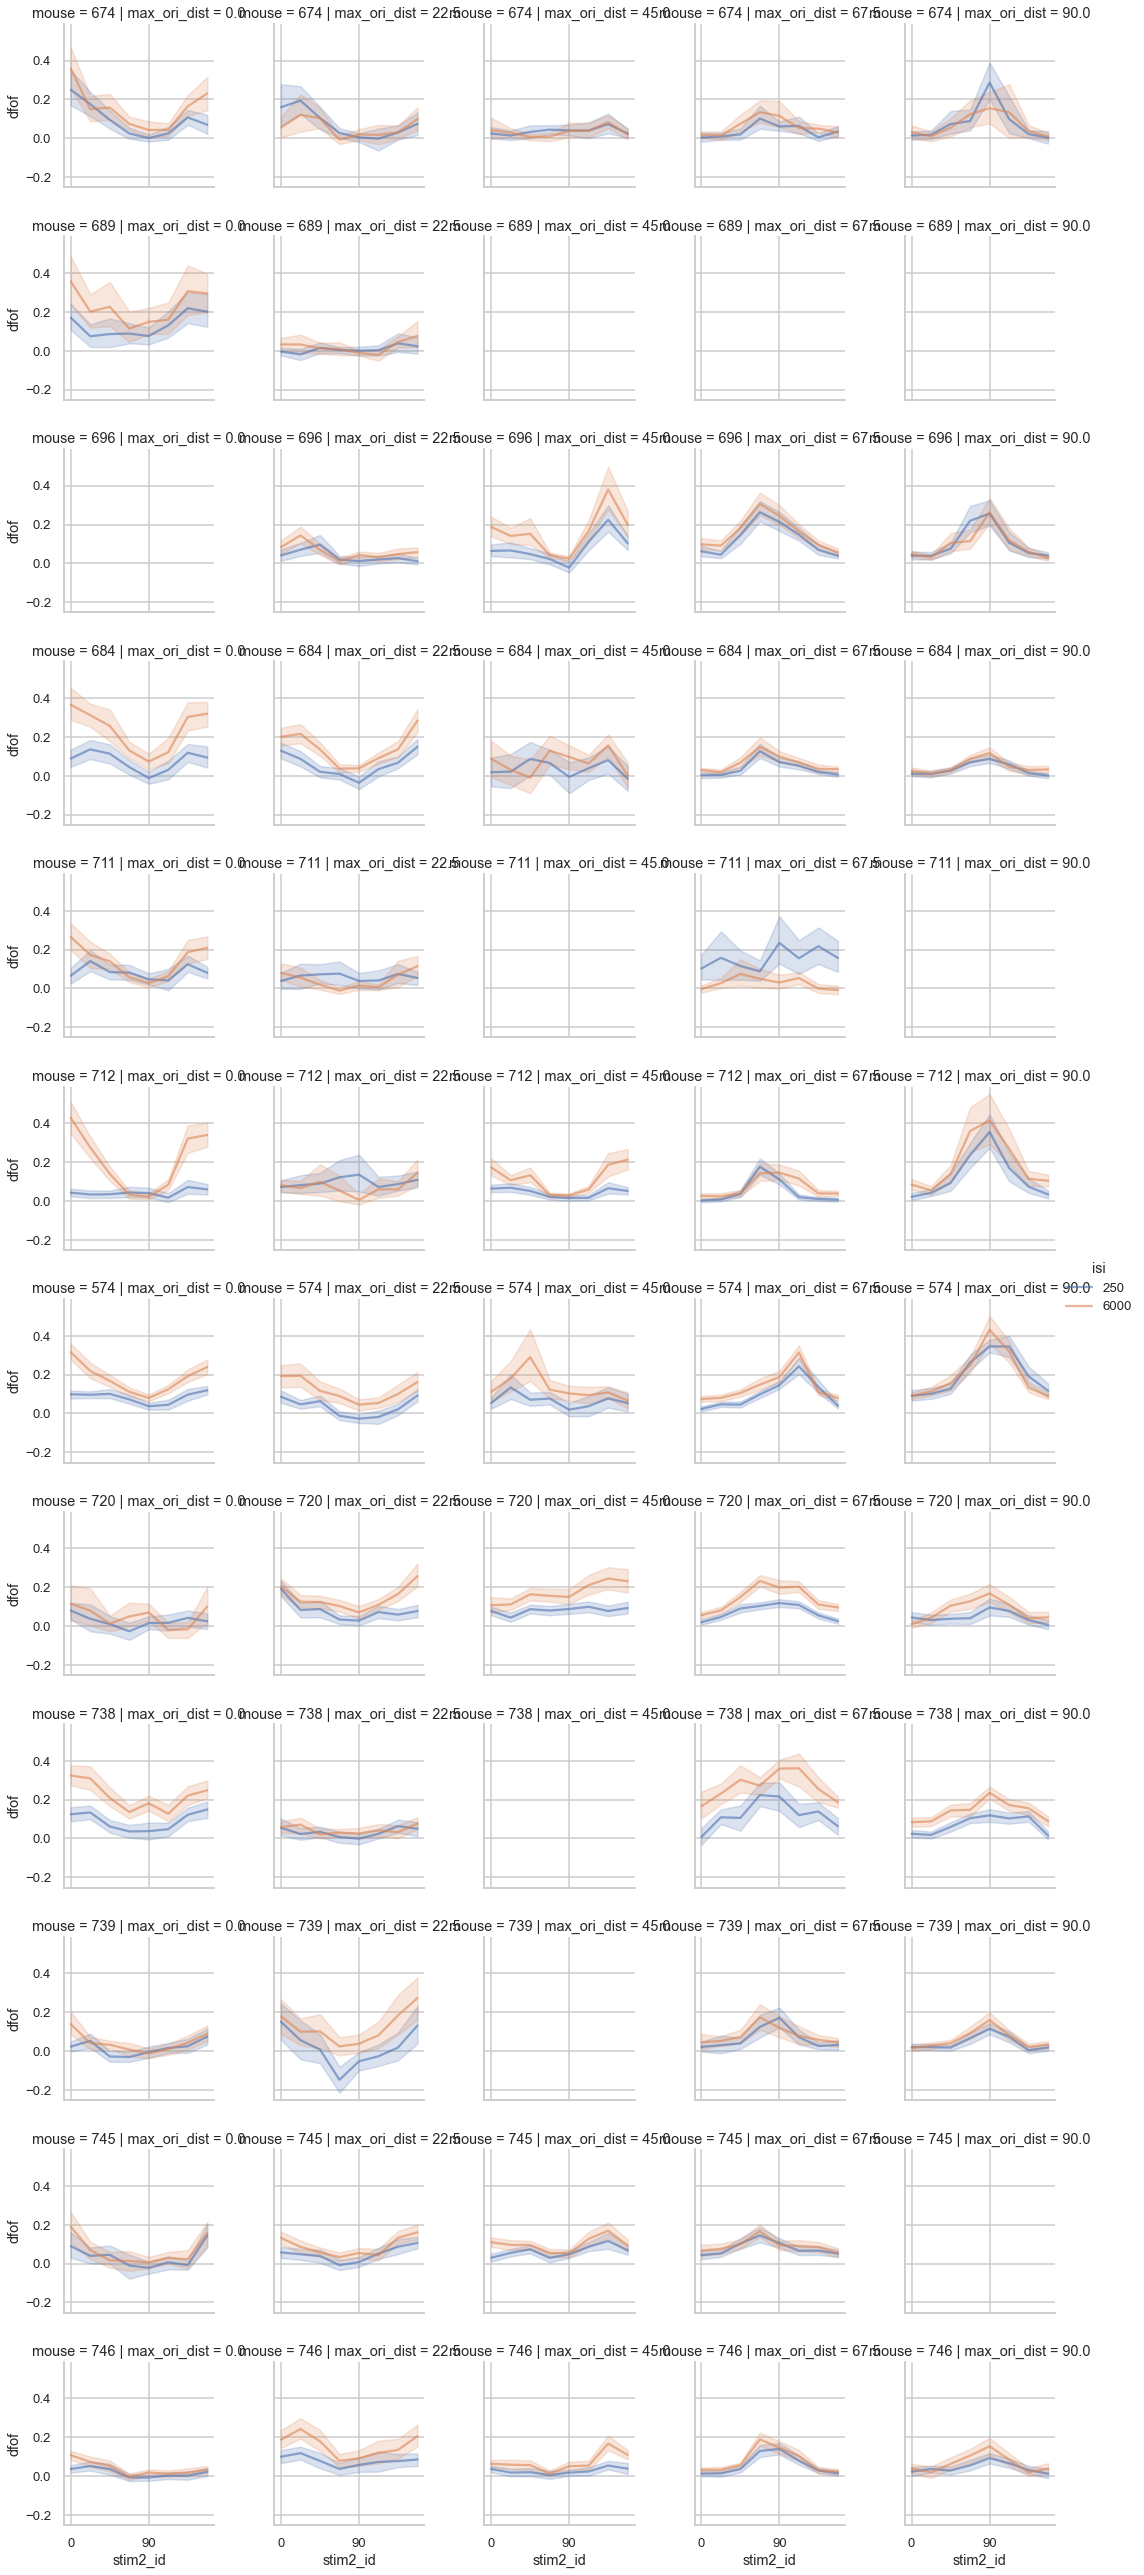

In [62]:
df_filter = df_lineplot[(df_lineplot.area == 'V1') # check V1 only
                       & (df_lineplot.isi != 750)
                       & (df_lineplot.ori_mod == True)
                       & (df_lineplot.filter_cell_vis == True)
                       ]

sns.set(font_scale=0.8, context='talk', style='whitegrid')
# g = sns.FacetGrid(df_filter, col="area", row="max_ori_dist", hue="isi")
g = sns.FacetGrid(df_filter, col="max_ori_dist", row="mouse", hue="isi") # which date has the most outrageous adp at orthogonal ori relative to adapter ori
g.map_dataframe(sns.lineplot, x="stim2_id", y="dfof", alpha=0.6)
g.figure.subplots_adjust(wspace=0.4, hspace=0.3)
g.add_legend();

# set xticks to 0, 4
for ax in g.axes.flat:
    ax.set_xticks([0, 4])
    ax.set_xticklabels(['0', '90'])

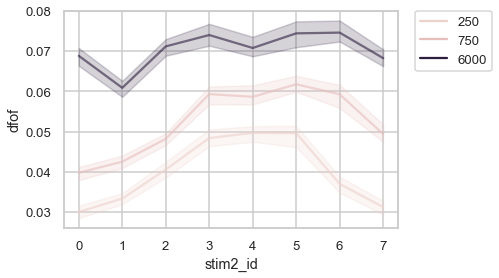

In [72]:
df_filter = df_lineplot[(df_lineplot.area == 'V1') # check V1 only
                    #    & (df_lineplot.isi != 750)
                       & (df_lineplot.ori_mod == True)
                       & (df_lineplot.filter_cell_vis == True)
                       ]

sns.lineplot(data=df_filter, x='stim2_id', y='dfof', hue='isi', ci=68, alpha=0.6, estimator=np.median)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

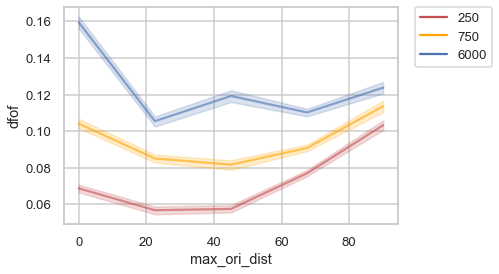

In [75]:
sns.lineplot(data=df_filter, x='max_ori_dist', y='dfof', hue='isi', ci=68, alpha=0.6, 
            estimator=np.mean, 
            palette=['r', 'orange', 'b'],)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [121]:
## for each cell_id, divide tuning_vec of isi 250 by tuning_vec of isi 6000
tmp = df_lineplot.groupby(['cell_id', 'isi']).tuning_vec.first().to_frame()
tmp

## split tuning_vec into 8 columns
tmp = tmp.tuning_vec.apply(pd.Series)
tmp

# plt.hist(tmp.values.flatten(), bins=100);
# min(tmp.values.flatten()), max(tmp.values.flatten())

tmp_noad = (tmp.groupby(level=['cell_id']).transform('last'))
tmp_noad

result = tmp - tmp_noad
result

## merge 8 columns back to tuning_vec
result['tuning_diff']= result.values.tolist()
result

## merge tuning_diff back to df_lineplot
df_lineplot = df_lineplot.loc[:, df_lineplot.columns != 'tuning_diff'].merge( # prevent duplicate column
        result.loc[:, 'tuning_diff'].reset_index(), # NOTE tuning_diff is (tuning_ad250 - tuning_noad)
        on=['cell_id', 'isi'], how='left')
df_lineplot

,dfof,cell_id,area,filter_cell_vis,resp_id,isi,stim2_id,ori_mod,max_ori,max_ori_dist,tuning_vec,tuning_diff
0,0.614854,170324_674_0,V1,True,R2,750,5,True,5,67.5,"[-0.003747857892641345, 0.02574579909775683, 0...","[-0.0023835421010714323, 0.020474480639817494,..."
1,0.099134,170324_674_0,V1,True,R2,250,3,True,5,67.5,"[0.008913068308823267, -0.021396008957600476, ...","[0.01027738410039318, -0.026667327415539815, -..."
2,0.013130,170324_674_0,V1,True,R2,6000,6,True,5,67.5,"[-0.0013643157915699125, 0.005271318457939338,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,0.072787,170324_674_0,V1,True,R2,6000,6,True,5,67.5,"[-0.0013643157915699125, 0.005271318457939338,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,0.224765,170324_674_0,V1,True,R2,6000,7,True,5,67.5,"[-0.0013643157915699125, 0.005271318457939338,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...
240885,-0.001696,170826_746_48,V1,True,R2,250,4,False,0,0.0,"[0.00019849356526639936, 0.04753583625073863, ...","[-0.038694530647588946, 0.02505956442857877, 0..."
240886,-0.023031,170826_746_48,V1,True,R2,250,1,False,0,0.0,"[0.00019849356526639936, 0.04753583625073863, ...","[-0.038694530647588946, 0.02505956442857877, 0..."
240887,-0.008022,170826_746_48,V1,True,R2,750,2,False,0,0.0,"[0.0550250135607704, 0.04056128350911568, 0.00...","[0.016131989347915057, 0.018085011686955817, 0..."
240888,0.008595,170826_746_48,V1,True,R2,250,7,False,0,0.0,"[0.00019849356526639936, 0.04753583625073863, ...","[-0.038694530647588946, 0.02505956442857877, 0..."


In [122]:
df_filter = df_lineplot[(df_lineplot.area == 'V1') # check V1 only
                       & (df_lineplot.ori_mod == True)
                       & (df_lineplot.filter_cell_vis == True)
                       ]
df_filter

,dfof,cell_id,area,filter_cell_vis,resp_id,isi,stim2_id,ori_mod,max_ori,max_ori_dist,tuning_vec,tuning_diff
0,0.614854,170324_674_0,V1,True,R2,750,5,True,5,67.5,"[-0.003747857892641345, 0.02574579909775683, 0...","[-0.0023835421010714323, 0.020474480639817494,..."
1,0.099134,170324_674_0,V1,True,R2,250,3,True,5,67.5,"[0.008913068308823267, -0.021396008957600476, ...","[0.01027738410039318, -0.026667327415539815, -..."
2,0.013130,170324_674_0,V1,True,R2,6000,6,True,5,67.5,"[-0.0013643157915699125, 0.005271318457939338,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,0.072787,170324_674_0,V1,True,R2,6000,6,True,5,67.5,"[-0.0013643157915699125, 0.005271318457939338,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,0.224765,170324_674_0,V1,True,R2,6000,7,True,5,67.5,"[-0.0013643157915699125, 0.005271318457939338,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...
240450,0.038607,170826_746_47,V1,True,R2,250,4,True,0,0.0,"[0.05059877163684573, 0.02501718292118449, 0.0...","[-0.07611082952310189, -0.03165719909315228, -..."
240451,-0.051810,170826_746_47,V1,True,R2,250,1,True,0,0.0,"[0.05059877163684573, 0.02501718292118449, 0.0...","[-0.07611082952310189, -0.03165719909315228, -..."
240452,-0.093837,170826_746_47,V1,True,R2,750,2,True,0,0.0,"[0.07402146949906126, 0.0701438796149059, 0.04...","[-0.05268813166088636, 0.013469497600569126, -..."
240453,0.022636,170826_746_47,V1,True,R2,250,7,True,0,0.0,"[0.05059877163684573, 0.02501718292118449, 0.0...","[-0.07611082952310189, -0.03165719909315228, -..."


In [123]:
df_tuning_diff = df_filter.groupby(['cell_id', 'isi']).tuning_diff.first().to_frame()
df_tuning_diff = df_tuning_diff.tuning_diff.apply(pd.Series)

# rename columns by adding 'stim' to each column
df_tuning_diff = df_tuning_diff.rename(columns={i: 'stim' + str(i) for i in range(8)})
df_tuning_diff = df_tuning_diff.reset_index()
df_tuning_diff

# pivot table so stim is row
df_tuning_diff = df_tuning_diff.melt(id_vars=['cell_id', 'isi'], var_name='stim', value_name='tuning_diff')
df_tuning_diff

# for stim col, take only the last char
df_tuning_diff['stim'] = df_tuning_diff.stim.apply(lambda x: x[-1])
df_tuning_diff.stim = df_tuning_diff.stim.astype(int)
df_tuning_diff['ori_dist'] = df_tuning_diff.stim.apply(lambda x: 22.5*(8-x) if x > 4 else 22.5*x) # distance from 0 deg, hard coded for 8 ori. TODO: modify if needed. here, we dont align by max ori of cells (to group cells), instead we plot all cells
df_tuning_diff

,cell_id,isi,stim,tuning_diff,ori_dist
0,170323_689_10,250,0,-0.106643,0.0
1,170323_689_10,750,0,-0.078250,0.0
2,170323_689_10,6000,0,0.000000,0.0
3,170323_689_11,250,0,-0.036568,0.0
4,170323_689_11,750,0,-0.016187,0.0
...,...,...,...,...,...
5179,170826_746_5,750,7,-0.004944,22.5
5180,170826_746_5,6000,7,0.000000,22.5
5181,170826_746_7,250,7,-0.093511,22.5
5182,170826_746_7,750,7,0.007412,22.5


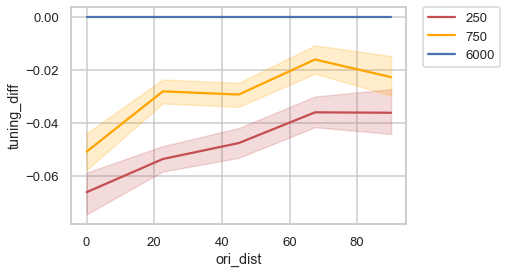

In [124]:
## set sns color palette
sns.lineplot(data=df_tuning_diff, x='ori_dist', y='tuning_diff', hue='isi', ci=68, #alpha=0.9,
            # estimator=np.median, 
            palette=['r', 'orange', 'b'],
            )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

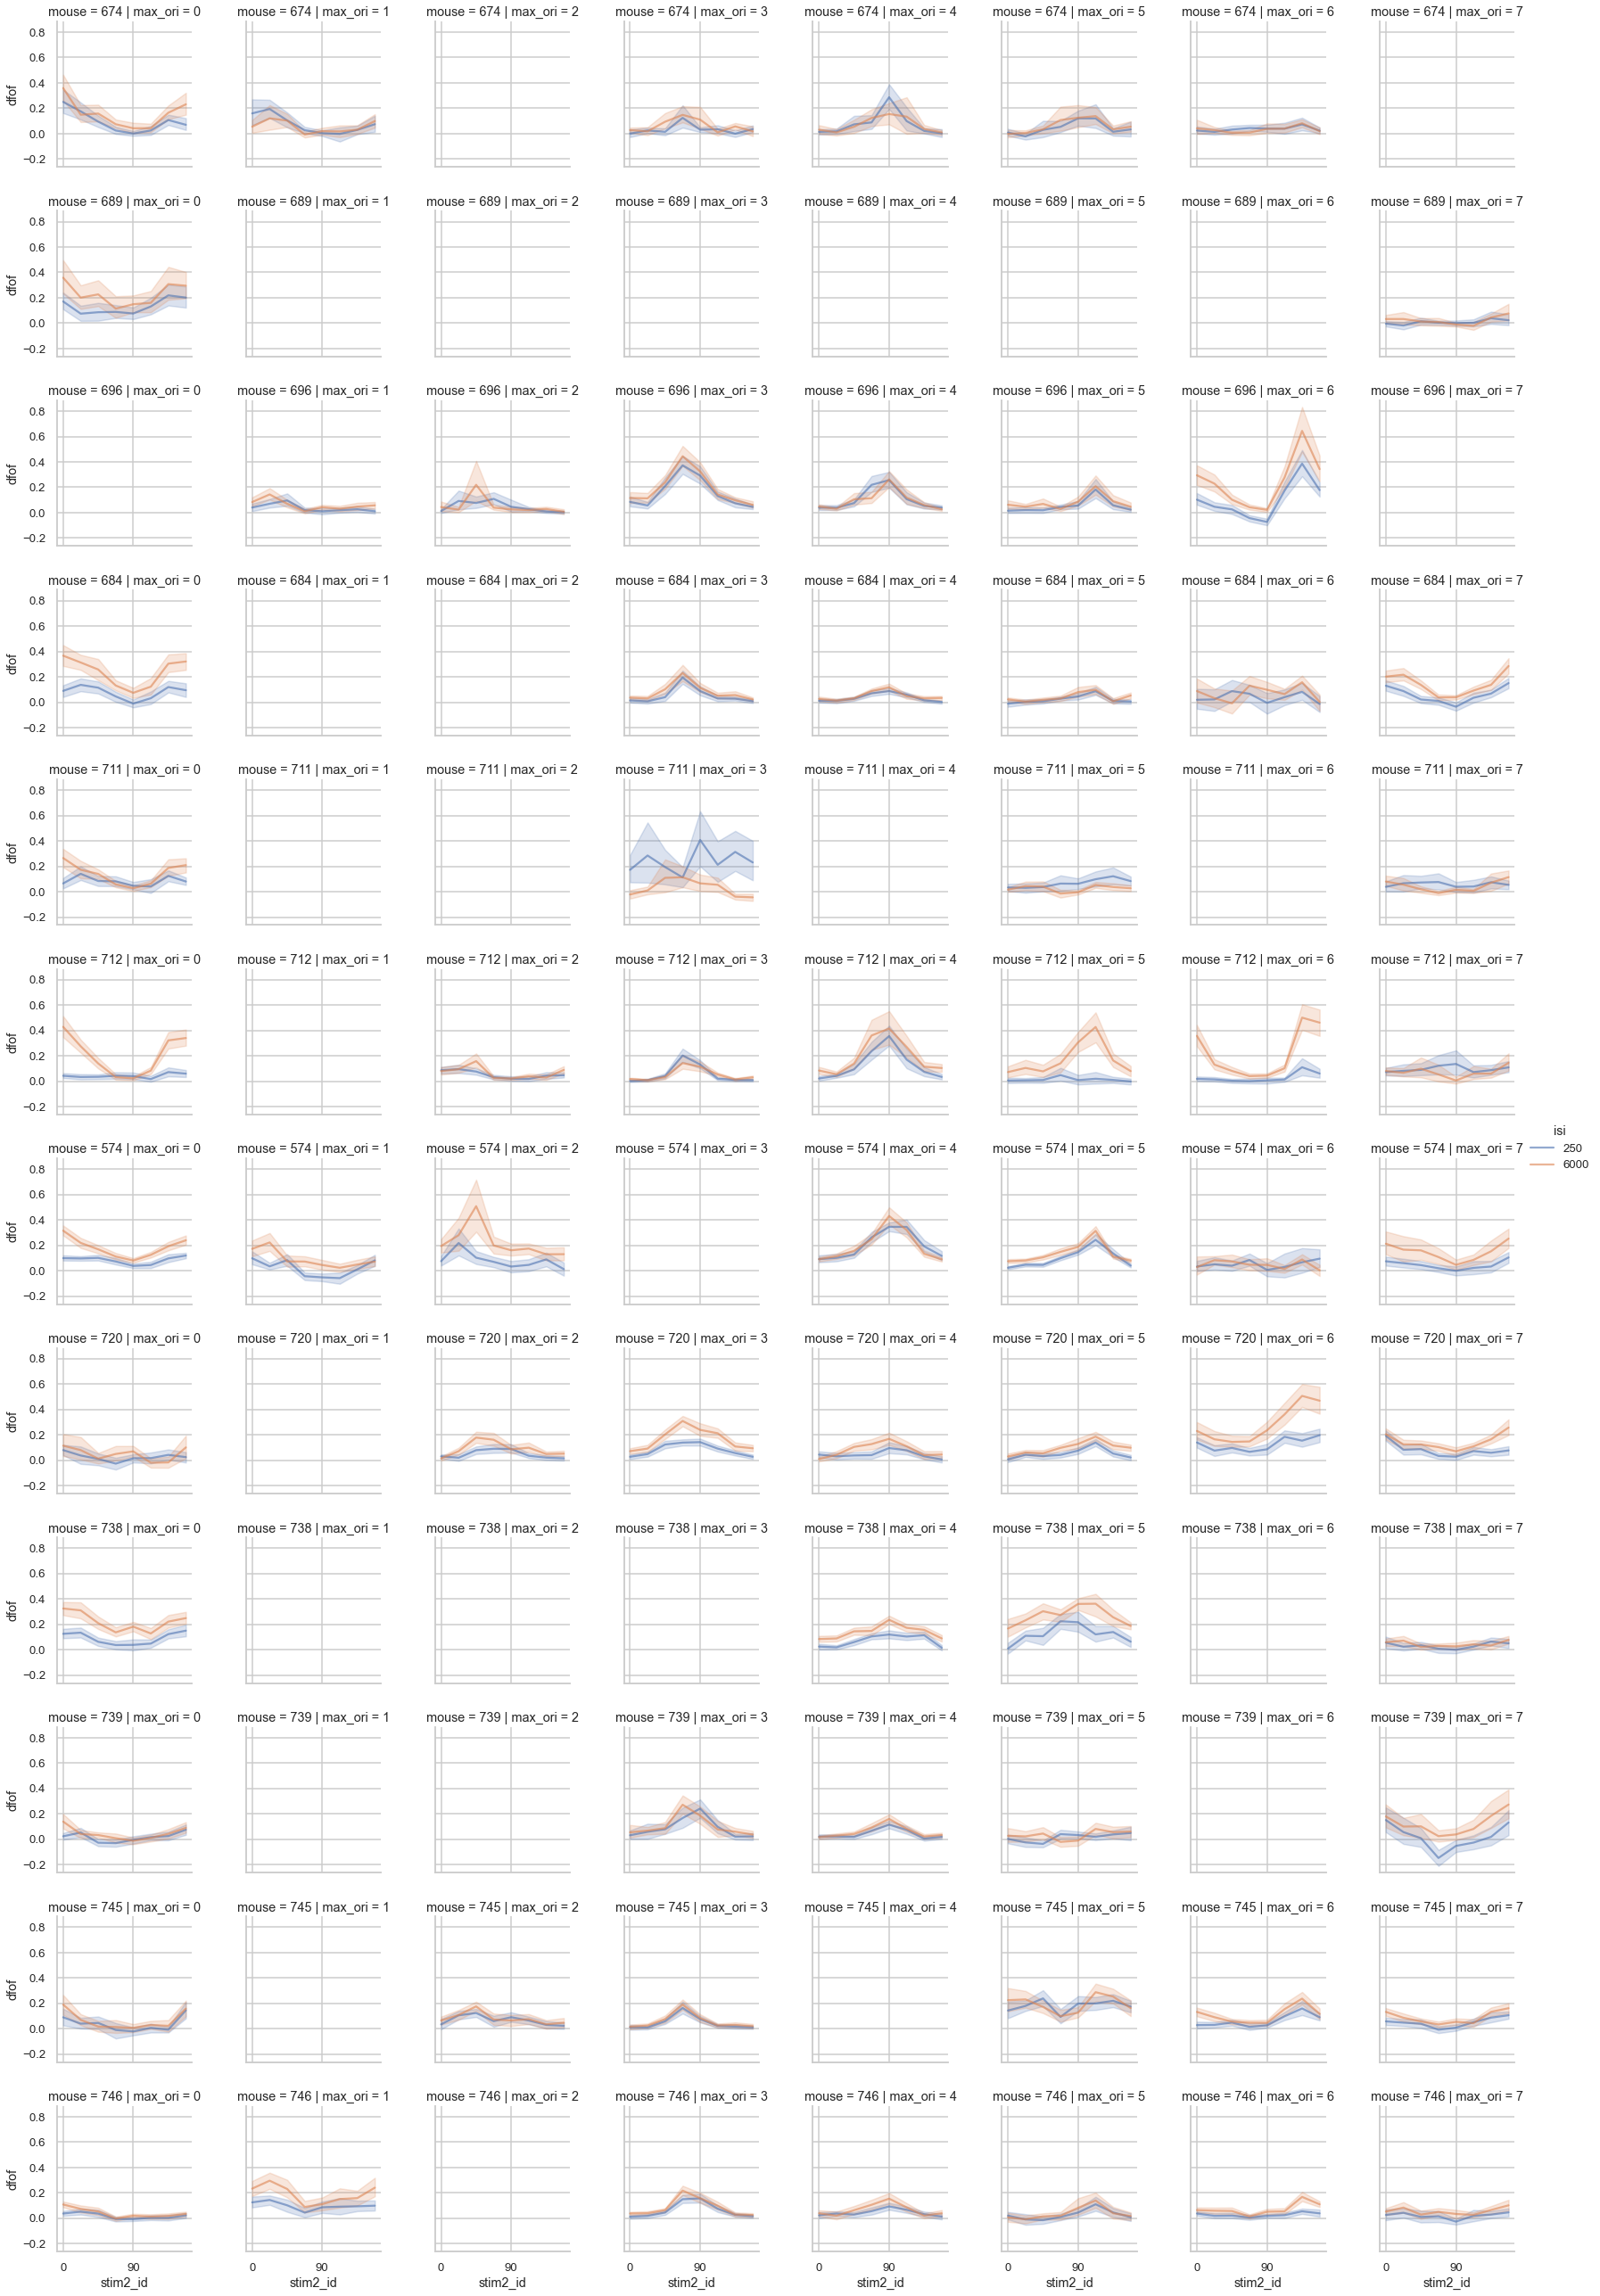

In [63]:
sns.set(font_scale=0.8, context='talk', style='whitegrid')
# g = sns.FacetGrid(df_filter, col="area", row="max_ori", hue="isi")
g = sns.FacetGrid(df_filter, col="max_ori", row="mouse", hue="isi")
g.map_dataframe(sns.lineplot, x="stim2_id", y="dfof", alpha=0.6)
g.figure.subplots_adjust(wspace=0.4, hspace=0.3)
g.add_legend();

for ax in g.axes.flat:
    ax.set_xticks([0, 4])
    ax.set_xticklabels(['0', '90'])

# san check
what can generate possibly fake adp when adapter vs target are orthogonal?  
check if bin=90 tuning curve is real: plot timecourse for stim2=90, noad vs 250

In [ ]:
df_lineplot[df_lineplot.area == 'V1'].groupby(['date', 'sess']).cell_id.nunique() # 201209-sess002 has highest ncell for V1 data
# 210120 & 201015 has the most outrageous adp at stim2=90. let's try use 210120

date    sess
200720  003     103
200728  003      93
200803  002      97
201015  004      82
201209  002     146
210120  003      62
Name: cell_id, dtype: int64

In [335]:
df_test = df_lineplot[(df_lineplot.date == '210120')] # use this date and sess for sanity check
df_test.cell_id = df_test.cell_id.apply(lambda x: x.split('_')[-1]) # temporarily remove date from cell_id
df_test

C:\Users\ll357\AppData\Local\Temp\6\ipykernel_43944\1917010594.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.cell_id = df_test.cell_id.apply(lambda x: x.split('_')[-1]) # temporarily remove date from cell_id


,dfof,cell_id,area,filter_cell_vis,resp_id,isi,stim2_id,ori_mod,max_ori,max_ori_dist,date,sess
241305,-0.059959,0,V1,True,R2,250,4,False,1,22.5,210120,003
241306,-0.066803,0,V1,True,R2,250,3,False,1,22.5,210120,003
241307,0.055740,0,V1,True,R2,6000,4,False,1,22.5,210120,003
241308,-0.104743,0,V1,True,R2,250,0,False,1,22.5,210120,003
241309,0.035202,0,V1,True,R2,750,4,False,1,22.5,210120,003
...,...,...,...,...,...,...,...,...,...,...,...,...
270068,-0.015048,61,V1,True,R2,250,5,True,6,45.0,210120,003
270069,0.027682,61,V1,True,R2,750,2,True,6,45.0,210120,003
270070,0.091247,61,V1,True,R2,750,1,True,6,45.0,210120,003
270071,-0.030568,61,V1,True,R2,250,0,True,6,45.0,210120,003


In [369]:
df_filter = df_test[(df_test.filter_cell_vis == True)
                    # & (df_test.ori_mod == True)
                    & (df_test.isi != 750)
                    ]
df_filter.cell_id.nunique(), df_test.cell_id.nunique()

cell_id_bool = pd.DataFrame(df_test.cell_id.astype(int).unique()).isin(df_filter.cell_id.astype(int).unique())
cell_id_bool.head(20) # whether this cell passes the filter (vis and ori_mod)
cell_id_bool = cell_id_bool.values.astype(int).flatten()
cell_id_bool

import scipy.io as sio
dir_mat = r'C:\Users\ll357\Documents\inter\results\tuning curve bias san check/'.replace('\\', '/')
# sio.savemat(dir_mat+'vis_orimod_cell_bool.mat', {'vis_orimod_cell_bool': cell_id_bool})
sio.savemat(dir_mat+'vis_cell_bool.mat', {'vis_cell_bool': cell_id_bool}) # if only filter by vis, not ori_mod